In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import nrrd
import json
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from allensdk.api.queries.ontologies_api import OntologiesApi
import requests
from anatomy.anatomy_api import AnatomyApi
import scipy.stats as stats
import statsmodels.api as sm
from scipy.optimize import curve_fit
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.graphics import utils

import seaborn as sns
sns.set_context('paper')
sns.set_style('white')

%matplotlib inline
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

distance_threshold = 800
overlap_threshold = 0.02

/Users/jenniferwh/Dropbox (Allen Institute)/Mesoscale Connectome Papers in Progress/2019 DMN/_new_figures/jupyter_notebooks/env/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
import platform
if platform.system() == 'Darwin':
    path = '/Users/jenniferwh/Dropbox/DMN data/correlations'
elif platform.system() == 'Windows':
    path = r'C:\Users\jenniferwh\Dropbox\DMN data\correlations'

In [3]:
# including primary/secondary switch matches within 500 um, all others no distance or overlap constraint
alldat = pd.read_csv(os.path.join(path, 'td_wt_cre_matched_correlations_NPV_dice.csv'))
c_by_source = pd.read_csv(os.path.join(path, 'match_correlations_by_source_NPV_dice.csv'))
c_by_source = c_by_source[c_by_source['same_primary'] == True]
c_by_source = c_by_source[c_by_source['same secondary for <60% primary'] != False]
print(len(alldat))
print(len(c_by_source))

10581
3077


In [4]:
# remove duplicates
c_by_source['index_original'] = c_by_source.groupby(['match_A', 'match_B']).match_A.transform('idxmin')    
c_by_source = c_by_source[~c_by_source.duplicated(subset=['match_A', 'match_B'], keep='first')]
for isid in c_by_source['match_A'].unique():
    Bmatches = c_by_source[c_by_source['match_A'] == isid]['match_B'].values
    Amatches = c_by_source[c_by_source['match_B'] == isid]['match_A'].values
    duplicates = [match for match in Amatches if match in Bmatches]
    if len(duplicates) > 0:
        print(Bmatches)
        print(Amatches)

In [5]:
# experiments with leakage, tile edges, low GFP signal, surface artifacts, wrong injection site assigned,
# or not all layers labeled, looks like PT cells only
td_dataset = pd.read_csv(r'/Users/jenniferwh/Dropbox (Allen Institute)/Mesoscale Connectome Papers in Progress/2019 DMN/target_defined_dataset.csv')
alldat = alldat.merge(td_dataset[['image_series_id', 'include']], on='image_series_id', 
                      how = 'left')
alldat = alldat[alldat['include'] == 'yes']
fail_expts = [114008926, 120280939, 180073473, 180403712, 180601025, 183174303, 183329222,
              249396394, 296047806, 299446445, 301060890, 303784745, 480069939, 482578964, 
              506947040, 514333422, 525796603, 545428296, 559878074, 638314843, 182888003,
             304585910, 183171679, 272930013, 523718075, 517072832, 148964212, 304762965,
             174361040, 566992832, 272930013, 304762965, 266250904, 114399224]
alldat = alldat[~alldat['match_id'].isin(fail_expts)]
c_by_source = c_by_source[~c_by_source['match_A'].isin(fail_expts)]
c_by_source = c_by_source[~c_by_source['match_B'].isin(fail_expts)]
print(len(c_by_source))
print(len(alldat))

2419
7441


In [6]:
aapi = AnatomyApi()
ss = aapi.get_summary_structure_data('id')
mcc = MouseConnectivityCache(manifest_file = '../connectivity/mouse_connectivity_manifest.json')
structure_tree = mcc.get_structure_tree()
isocortex = structure_tree.get_structures_by_acronym(['Isocortex'])[0]
HPF = structure_tree.get_structures_by_acronym(['HPF'])[0]
iso = structure_tree.descendant_ids([isocortex['id']])[0]
iso = [structure for structure in iso if structure in ss]
hipp = structure_tree.descendant_ids([HPF['id']])[0]
hipp = [structure for structure in hipp if structure in ss]
ia_map = structure_tree.get_id_acronym_map()
ai_map = {value:key for key, value in ia_map.items()}
ctx_strs = [ai_map[structure] for structure in iso]
hipp_strs = [ai_map[structure] for structure in hipp]
valid_strs = ctx_strs+hipp_strs

In [7]:
c_by_source['source'] = c_by_source['match_A_primary_source']
# Use only the sources that are in the dataset as controls
c_ctx = c_by_source[(c_by_source['match_A_primary_source'].isin(ctx_strs)) |
                    (c_by_source['match_B_primary_source'].isin(ctx_strs))]
alldat_ctx = alldat[alldat['source'].isin(ctx_strs)]

#c_by_source = c_by_source[c_by_source['source'].isin(valid_strs)]
#alldat = alldat[alldat['source'].isin(valid_strs)]
c_by_source = c_by_source[c_by_source['distance'] < distance_threshold]
c_ctx = c_ctx[c_ctx['distance'] < distance_threshold]
alldat = alldat[alldat['distance'] < distance_threshold]
alldat_ctx = alldat_ctx[alldat_ctx['distance'] < distance_threshold]

c_by_source = c_by_source[c_by_source['dice_coefficient'] > overlap_threshold]
c_ctx = c_ctx[c_ctx['dice_coefficient'] > overlap_threshold]
alldat = alldat[alldat['dice_coefficient'] > overlap_threshold]
alldat_ctx = alldat_ctx[alldat_ctx['dice_coefficient'] > overlap_threshold]

print(len(c_by_source))
print(len(c_ctx))
print(len(alldat))
print(len(alldat_ctx))

801
709
1594
1379


In [8]:
alldat.keys()

Index(['image_series_id', 'match_id', 'distance', 'injection_overlap',
       'exclusion_zone_overlap', 'fraction of match covered by td injection',
       'fraction of match covered by td exclusion zone', 'dice_coefficient',
       'spearman_correlation', 'pearson_correlation', 'source',
       'td_secondary_source', 'td_percent_secondary', 'td_injection_size',
       'td_primary_source', 'td_percent_primary', 'match_secondary_source',
       'match_percent_secondary', 'match_injection_size',
       'match_primary_source', 'match_percent_primary', 'transgenic_line',
       'Virus', 'same_primary', 'same_secondary',
       'same secondary for <60% primary', 'injection_size_ratio', 'include'],
      dtype='object')

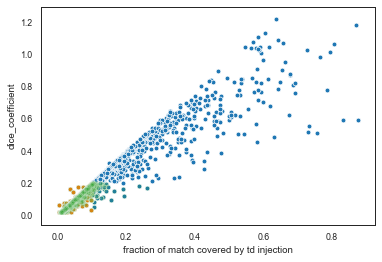

In [9]:
sns.scatterplot('fraction of match covered by td injection',
               'dice_coefficient', data = alldat)
sns.scatterplot('fraction of match covered by td injection',
               'dice_coefficient', 
                data = alldat[alldat['fraction of match covered by td injection'] < 0.1])
sns.scatterplot('fraction of match covered by td injection',
               'dice_coefficient', 
                data = alldat[alldat['dice_coefficient'] < 0.2],
               alpha = 0.2)

In [10]:
#slope, intercept, r_value, p_value, std_error 
m, b, r1, p1, se = stats.linregress(c_by_source['match_B_injection_size'], c_by_source['spearman_correlation'])
m, b, r2, p2, se = stats.linregress(c_by_source['match_A_injection_size'], c_by_source['spearman_correlation'])
m, b, r3, p3, se = stats.linregress(c_by_source['distance'], c_by_source['spearman_correlation'])
m, b, r4, p4, se = stats.linregress(c_by_source['dice_coefficient'], 
                                    c_by_source['spearman_correlation'])
m, b, r5, p5, se = stats.linregress(c_by_source['injection_overlap'], 
                                    c_by_source['spearman_correlation'])
m, b, r6, p6, se = stats.linregress(alldat['td_injection_size'], alldat['spearman_correlation'])
m, b, r7, p7, se = stats.linregress(alldat['match_injection_size'], alldat['spearman_correlation'])
m, b, r8, p8, se = stats.linregress(alldat['distance'], alldat['spearman_correlation'])
m, b, r9, p9, se = stats.linregress(alldat['injection_overlap'], alldat['spearman_correlation'])
m, b, r10, p10, se = stats.linregress(alldat['dice_coefficient'], 
                                      alldat['spearman_correlation'])

fdrcorr = sm.stats.fdrcorrection([p1, p2, p3, p4, p5, p6, p7, p8, p9, p10], alpha=0.05, method='indep')
print(fdrcorr)
print(r1)
print(r2)
print(r3)
print(r4)
print(r5)
print(r6)
print(r7)
print(r8)
print(r9)
print(r10)

(array([ True,  True,  True,  True,  True,  True, False,  True,  True,
        True]), array([8.20892104e-07, 2.00213015e-26, 1.81091907e-04, 7.37923761e-12,
       1.18007162e-04, 2.11949047e-13, 5.66954009e-02, 9.63491848e-13,
       1.84574619e-09, 3.67116066e-19]))
0.17555118523602056
0.3702260430001845
-0.13283735446329692
0.24222910362576688
0.13751885178222323
0.186362658065041
0.047741108557330394
-0.18050205787560988
0.15184727795021533
0.22571312055505108


/Users/jenniferwh/Dropbox (Allen Institute)/Mesoscale Connectome Papers in Progress/2019 DMN/_new_figures/jupyter_notebooks/env/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


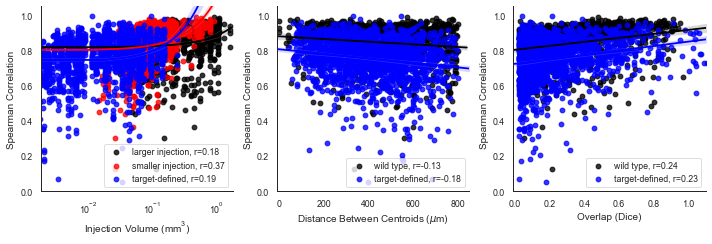

In [11]:
fig, ax = plt.subplots(1, 3, figsize = (10, 3.5), sharey = False)
sns.regplot('match_B_injection_size', 'spearman_correlation', data = c_by_source, ax = ax[0], color = 'k',
           label = 'larger injection, r={0}'.format(r1.round(2)))
sns.regplot('match_A_injection_size', 'spearman_correlation', data = c_by_source, ax = ax[0], color = 'r',
           label = 'smaller injection, r={0}'.format(r2.round(2)))
sns.regplot('td_injection_size', 'spearman_correlation', data = alldat, ax = ax[0], color = 'b',
           label = 'target-defined, r={0}'.format(r6.round(2)))
sns.regplot('distance', 'spearman_correlation', data = c_by_source, ax = ax[1], color = 'k', 
            label = 'wild type, r={0}'.format(r3.round(2)))
sns.regplot('distance', 'spearman_correlation', data = alldat, ax = ax[1], color = 'b', 
            label = 'target-defined, r={0}'.format(r8.round(2)))
sns.regplot('dice_coefficient', 'spearman_correlation', data = c_by_source, ax = ax[2],
           color = 'k', label = 'wild type, r={0}'.format(r4.round(2)))
sns.regplot('dice_coefficient', 'spearman_correlation', data = alldat, ax = ax[2],
           color = 'b', label = 'target-defined, r={0}'.format(r10.round(2)))
ax[0].set_xscale('log')
ax[0].set_ylim([0,1.05])
ax[1].set_ylim([0,1.05])
ax[2].set_ylim([0,1.05])
ax[0].set_xlim([-0.05, 1.8])
ax[1].set_xlim([-10, 850])
ax[2].set_xlim([-0.01, 1.1])
sns.despine()
ax[0].tick_params(top = False, right = False)
ax[1].tick_params(top = False, right = False)
ax[2].tick_params(top = False, right = False)
ax[0].set_ylabel('Spearman Correlation', fontsize = 10)
ax[1].set_ylabel('Spearman Correlation', fontsize = 10)
ax[2].set_ylabel('Spearman Correlation', fontsize = 10)
ax[0].set_xlabel(r'Injection Volume (mm$\mathregular{^{3}}$)', fontsize = 10)
ax[1].set_xlabel('Distance Between Centroids ($\mu$m)', fontsize = 10)
ax[2].set_xlabel('Overlap (Dice)', fontsize = 10)
ax[0].legend(loc = 4)
ax[1].legend(loc=4)
ax[2].legend(loc=4)
plt.tight_layout()
plt.savefig(os.path.join(path, 'dependence of corr on size distance overlap.pdf'), 
            bbox_inches='tight', pad_inches=0.3, format='pdf', dpi=300)

In [12]:
print(len(alldat['image_series_id'].unique()))
len(alldat[alldat['td_injection_size'] < c_by_source['match_A_injection_size'].min()]['image_series_id'].unique())

151


84

In [13]:
df2 = alldat.copy().reset_index()
df2.rename(columns = {'image_series_id': 'match_A', 'source': 'match_A_primary_source',
                      'td_percent_primary': 'match_A_percent_primary', 
                      'td_secondary_source': 'match_A_secondary_source',
                      'td_percent_secondary': 'match_A_percent_secondary',
                      'match_id': 'match_B', 'match_primary_source': 'match_B_primary_source',
                      'match_percent_primary': 'match_B_percent_primary', 
                      'match_percent_secondary': 'match_B_percent_secondary',
                      'match_secondary_source': 'match_B_secondary_source', 
                      'td_injection_size': 'match_A_injection_size', 
                     'match_injection_size': 'match_B_injection_size',
                     'transgenic_line': 'transgenic_line_B', 'Virus': 'Virus_B'}, inplace = True)
df2['Virus_A'] = 'EGFP'
df2['transgenic_line_A'] = 'Ai75'
# assign smaller injection to match A, larger to match B
for index, row in df2.iterrows():
    if(row['match_A_injection_size'] > row['match_B_injection_size']):
        df2.loc[index,['match_A','match_B']] = df2.loc[
                index,['match_B','match_A']].values
        df2.loc[index,['match_A_injection_size','match_B_injection_size']] = df2.loc[
                index,['match_B_injection_size','match_A_injection_size']].values
        df2.loc[index,['dice_coefficient','injection_overlap']] = df2.loc[
                index,['injection_overlap','dice_coefficient']].values
        df2.loc[index,['transgenic_line_A','transgenic_line_B']] = df2.loc[
                index,['transgenic_line_B','transgenic_line_A']].values
        df2.loc[index,['Virus_A','Virus_B']] = df2.loc[
                index,['Virus_B','Virus_A']].values
        df2.loc[index,['match_A_primary_source','match_B_primary_source']] = df2.loc[
                index,['match_B_primary_source','match_A_primary_source']].values
        df2.loc[index,['match_A_secondary_source','match_B_secondary_source']] = df2.loc[
                index,['match_B_secondary_source','match_A_secondary_source']].values
        df2.loc[index,['match_A_percent_primary','match_B_percent_primary']] = df2.loc[
                index,['match_B_percent_primary','match_A_percent_primary']].values
        df2.loc[index,['match_A_percent_secondary','match_B_percent_secondary']] = df2.loc[
                index,['match_B_percent_secondary','match_A_percent_secondary']].values

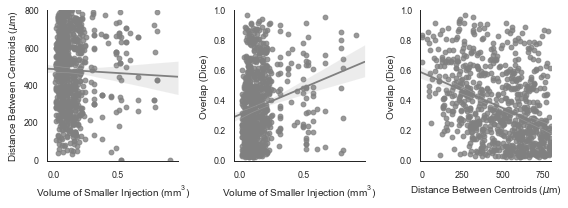

In [14]:
fig, ax = plt.subplots(1, 3, figsize = (8, 3))
sns.regplot('match_A_injection_size', 'distance', data = c_by_source, ax = ax[0], color='gray')
sns.regplot('match_A_injection_size', 'dice_coefficient', data = c_by_source, ax = ax[1],
           color = 'gray')
sns.regplot('distance', 'dice_coefficient', data = c_by_source, ax = ax[2], color = 'gray')
sns.despine()
ax[0].tick_params(top = False, right = False)
ax[1].tick_params(top = False, right = False)
ax[2].tick_params(top = False, right = False)
#ax[0].set_xlim([-0.05, 1])
#ax[1].set_xlim([-0.05, 1])
ax[2].set_xlim([-10, 800])
ax[0].set_ylim([-10, 800])
ax[1].set_ylim([-0.01, 1])
ax[2].set_ylim([-0.01, 1])
ax[0].set_ylabel('Distance Between Centroids ($\mu$m)', fontsize = 10)
ax[1].set_ylabel('Overlap (Dice)', fontsize = 10)
ax[2].set_ylabel('Overlap (Dice)', fontsize = 10)
ax[0].set_xlabel(r'Volume of Smaller Injection (mm$\mathregular{^{3}}$)', fontsize = 10)
ax[1].set_xlabel(r'Volume of Smaller Injection (mm$\mathregular{^{3}}$)', fontsize = 10)
ax[2].set_xlabel('Distance Between Centroids ($\mu$m)', fontsize = 10)
plt.tight_layout()
#plt.savefig(os.path.join(path, 'interdependence of distance volume overlap.pdf'), 
#            bbox_inches='tight', pad_inches=0.3, format='pdf', dpi=300)

In [15]:
m, b, r1, p1, se = stats.linregress(c_by_source['match_A_injection_size'], 
                                    c_by_source['distance'])
m, b, r2, p2, se = stats.linregress(c_by_source['match_A_injection_size'], 
                                    c_by_source['dice_coefficient'])
m, b, r3, p3, se = stats.linregress(c_by_source['distance'], 
                                    c_by_source['dice_coefficient'])

fdrcorr = sm.stats.fdrcorrection([p1, p2, p3], alpha=0.05, method='indep')
print(fdrcorr)
print(r1, r2, r3)

(array([False,  True,  True]), array([3.93366500e-01, 2.85677378e-09, 4.19626690e-29]))
-0.03019821490591246 0.2101566819673712 -0.38424600747132415


In [16]:
wt = c_by_source[c_by_source['transgenic_line_A'].isnull()]['match_A'].unique()
wt2 = c_by_source[c_by_source['transgenic_line_B'].isnull()]['match_B'].unique()
wt = np.append(wt, wt2)
print('wt: ', len(np.unique(wt)))
Emx = c_by_source[c_by_source['transgenic_line_A'] == 'Emx1-IRES-Cre']['match_A'].unique()
Emx2 = c_by_source[c_by_source['transgenic_line_B'] == 'Emx1-IRES-Cre']['match_B'].unique()
Emx = np.append(Emx, Emx2)
print('Emx1-Cre: ', len(np.unique(Emx)))
Rbp4 = c_by_source[c_by_source['transgenic_line_A'] == 'Rbp4-Cre_KL100']['match_A'].unique()
Rbp42 = c_by_source[c_by_source['transgenic_line_B'] == 'Rbp4-Cre_KL100']['match_B'].unique()
Rbp4 = np.append(Rbp4, Rbp42)
print('Rbp4-Cre: ', len(np.unique(Rbp4)))
other = c_by_source[(~c_by_source['transgenic_line_A'].isnull()) & 
                    (~c_by_source['transgenic_line_A'].isin(['Emx1-IRES-Cre', 'Rbp4-Cre_KL100']))]['match_A'].unique()
other2 = c_by_source[(~c_by_source['transgenic_line_B'].isnull()) & 
                    (~c_by_source['transgenic_line_B'].isin(['Emx1-IRES-Cre', 'Rbp4-Cre_KL100']))]['match_B'].unique()
other = np.append(other, other2)
print('other: ', len(np.unique(other)))

wt:  125
Emx1-Cre:  55
Rbp4-Cre:  76
other:  18


In [17]:
c_by_source['transgenic_line_A'].unique()

array([nan, 'Rbp4-Cre_KL100', 'Emx1-IRES-Cre', 'Calb1-T2A-dgCre',
       'Grp-Cre_KH288', 'Gpr26-Cre_KO250', 'Prkcd-GluCla-CFP-IRES-Cre',
       'Slc17a6-IRES-Cre', 'Ppp1r17-Cre_NL146', 'Grik4-Cre',
       'Foxp2-IRES-Cre'], dtype=object)

In [18]:
print(len(c_by_source[c_by_source['same secondary for <60% primary'] == True]))

KeyError: 'same secondary for <50% primary'

In [16]:
[structure for structure in ctx_strs if structure not in c_by_source['source'].values]

[u'AId',
 u'AIp',
 u'AIv',
 u'FRP',
 u'AUDv',
 u'SSp-un',
 u'TEa',
 u'VISli',
 u'ECT',
 u'PERI',
 u'GU']

In [17]:
c_by_source[(c_by_source['match_A_secondary_source'] == 'TEa') &
     (c_by_source['same secondary for <50% primary'] == True)][['match_A', 'match_B']]

,match_A,match_B
4444,606100558,579203888
4449,606100558,554421791
4455,642809043,554421791


In [18]:
print(c_by_source['match_A_injection_size'].max())

0.90878975


0.24219763100000002


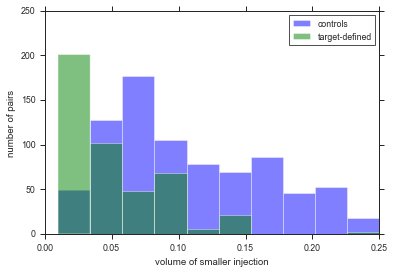

In [19]:
fig, ax = plt.subplots()
bins = np.linspace(0.01, 0.25, 11)
plt.hist(c_by_source['match_A_injection_size'].values, bins = bins, alpha = 0.5, label = 'controls');
plt.hist(alldat['td_injection_size'].values, bins = bins, alpha = 0.5, label = 'target-defined');
ax.set_ylabel('number of pairs')
ax.set_xlabel('volume of smaller injection')
ax.legend()
print(alldat['td_injection_size'].max())

In [20]:
print(len(c_by_source))
len(c_by_source[c_by_source['match_A_injection_size'] < 0.25])

907


810

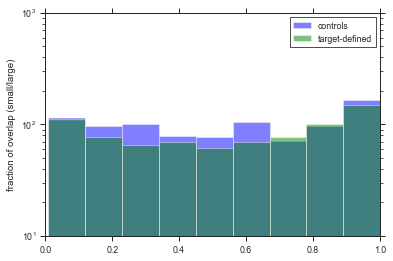

In [21]:
fig, ax = plt.subplots()
bins = np.linspace(0.01, 1, 10)
plt.hist(c_by_source['injection_overlap'].values, bins = bins, alpha = 0.5, 
         label = 'controls');
plt.hist(alldat['injection_overlap'].values, bins = bins, alpha = 0.5, 
         label = 'target-defined');
ax.set_yscale('log')
ax.set_ylabel('fraction of overlap (small/large)')
ax.legend()

796.3667497


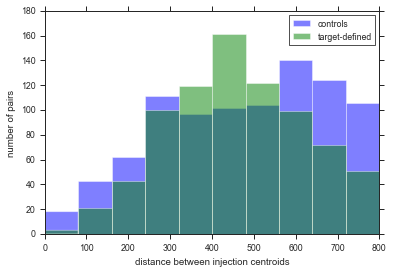

In [22]:
fig, ax = plt.subplots()
bins = np.linspace(0, 800, 11)
plt.hist(c_by_source['distance'].values, bins = bins, alpha = 0.5, label = 'controls');
plt.hist(alldat['distance'].values, bins = bins, alpha = 0.5, label = 'target-defined');
ax.set_ylabel('number of pairs')
ax.set_xlabel('distance between injection centroids')
ax.legend()
print(alldat['distance'].max())

LinregressResult(slope=0.0807227660259208, intercept=0.9123810975724349, rvalue=0.2584910824800328, pvalue=2.5968854773037297e-15, stderr=0.010027887209006622)


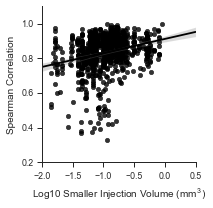

In [23]:
fig, ax = plt.subplots(figsize = (3, 3))
c_by_source['log_inj_size'] = np.log10(c_by_source['match_A_injection_size'])
sns.regplot('log_inj_size', 'spearman_correlation', data = c_by_source, color = 'k')
#ax.set_ylim([0,1.05])
#ax.set_xlim([-0.01, 1.01])
sns.despine()
ax.tick_params(top = False, right = False)
ax.set_ylabel('Spearman Correlation', fontsize = 10)
ax.set_xlabel(r'Log10 Smaller Injection Volume (mm$\mathregular{^{3}}$)', fontsize = 10)
plt.tight_layout()
#plt.savefig(os.path.join(path, 'log inj size vs correlation graph.pdf'), 
#            bbox_inches='tight', pad_inches=0.3, format='pdf', dpi=300)
print(stats.linregress(c_by_source['log_inj_size'], c_by_source['spearman_correlation']))

In [24]:
c_by_source[c_by_source['spearman_correlation'] < 0.5]['source'].unique()

array(['VISp', 'RE', 'AV', 'MD', 'DG'], dtype=object)

('size', 0.5064407421634449)


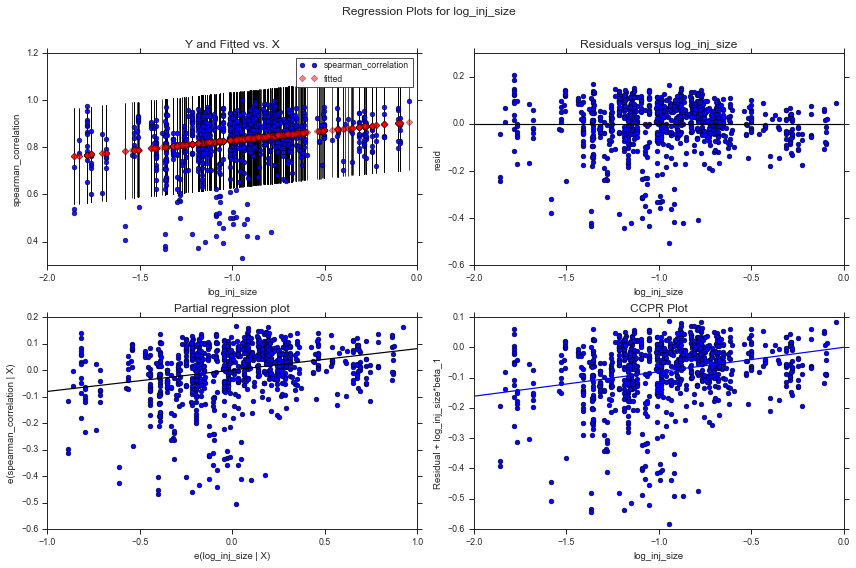

In [25]:
X = c_by_source[['log_inj_size']]
X = sm.add_constant(X)
y = c_by_source[['spearman_correlation']]

# fit GLM
fit = sm.OLS(y, X).fit()
print('size', np.max([fit.resid.max(), abs(fit.resid.min())]))
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(fit, "log_inj_size", fig = fig)

In [26]:
print(fit.summary())

                             OLS Regression Results                             
Dep. Variable:     spearman_correlation   R-squared:                       0.067
Model:                              OLS   Adj. R-squared:                  0.066
Method:                   Least Squares   F-statistic:                     64.80
Date:                  Wed, 03 Apr 2019   Prob (F-statistic):           2.60e-15
Time:                          18:43:03   Log-Likelihood:                 773.88
No. Observations:                   907   AIC:                            -1544.
Df Residuals:                       905   BIC:                            -1534.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.9124     

9.638940354363873


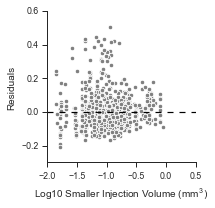

In [27]:
y_fit = fit.predict(X).values
resids = (y_fit-np.array([value[0] for value in y.values]))
fig, ax = plt.subplots(figsize = (3,3))
plt.scatter(c_by_source[['log_inj_size']], resids, c = 'gray')
plt.axhline(y=0, c='k', linestyle = '--')
sns.despine()
ax.tick_params(top = False, right = False)
ax.set_ylabel('Residuals', fontsize = 10)
ax.set_xlabel(r'Log10 Smaller Injection Volume (mm$\mathregular{^{3}}$)', fontsize = 10)
plt.tight_layout()
#plt.savefig(os.path.join(path, 'log inj size linear fit residuals.pdf'), 
#            bbox_inches='tight', pad_inches=0.3, format='pdf', dpi=300)
print(np.sum(resids**2))

In [ ]:
X = c_by_source[['log_inj_size', 'distance']]
X = sm.add_constant(X)
y = c_by_source[['spearman_correlation']]

# fit GLM
fit = sm.OLS(y, X).fit()
print('size', np.max([fit.resid.max(), abs(fit.resid.min())]))
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(fit, "log_inj_size", fig = fig)

(array([ 0.17754969,  0.87397545, -0.13989229]), array([[2.32579120e-03, 3.54754617e-04, 5.02478580e-04],
       [3.54754617e-04, 8.69729451e-05, 1.83236797e-06],
       [5.02478580e-04, 1.83236797e-06, 3.72310561e-04]]))
0.0758200331323109


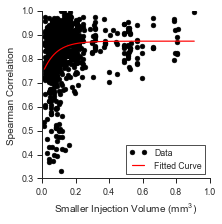

In [28]:
def exp(x, b, c, d):
    return d * 10**(-x / b) + c 

c_by_source.sort_values(by='match_A_injection_size', inplace = True)
X = c_by_source['match_A_injection_size'].values
y = c_by_source['spearman_correlation'].values
p0 = 1, 0.5, 0.1
popt_exp, pcov_exp = curve_fit(exp, X, y, p0)
print(popt_exp, pcov_exp)

fig, ax = plt.subplots(figsize = (3,3))
plt.plot(X, y, 'ko', label="Data")
plt.plot(X, exp(X, *popt_exp), 'r-', label="Fitted Curve")
plt.legend(loc = 4)
#ax.set_xlim([-0.01, 1])
sns.despine()
ax.tick_params(top = False, right = False)
ax.set_ylabel('Spearman Correlation', fontsize = 10)
ax.set_xlabel(r'Smaller Injection Volume (mm$\mathregular{^{3}}$)', fontsize = 10)
#plt.savefig(os.path.join(path, 'inj size exponential fit.pdf'), 
#            bbox_inches='tight', pad_inches=0.3, format='pdf', dpi=300)

y_fit_exp = exp(X, *popt_exp)
# residual sum of squares
ss_res = np.sum((y - y_fit_exp) ** 2)

# total sum of squares
ss_tot = np.sum((y - np.mean(y)) ** 2)

# r-squared
r2 = 1 - (ss_res / ss_tot)
print(r2)

9.5459536704905


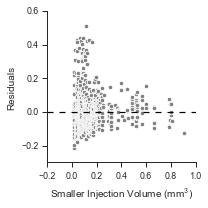

In [29]:
resids = y_fit_exp - y
fig, ax = plt.subplots(figsize = (3,3))
plt.scatter(X, resids, c = 'gray')
plt.axhline(y=0, c='k', linestyle = '--')
sns.despine()
ax.tick_params(top = False, right = False)
ax.set_ylabel('Residuals', fontsize = 10)
ax.set_xlabel(r'Smaller Injection Volume (mm$\mathregular{^{3}}$)', fontsize = 10)
plt.tight_layout()
#plt.savefig(os.path.join(path, 'inj size exp fit residuals.pdf'), 
#            bbox_inches='tight', pad_inches=0.3, format='pdf', dpi=300)
print(np.sum(resids**2))

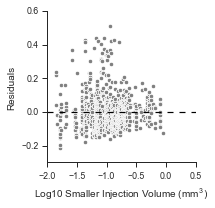

In [30]:
resids = (y_fit_exp-y)
fig, ax = plt.subplots(figsize = (3,3))
plt.scatter(c_by_source[['log_inj_size']], resids, c = 'gray')
plt.axhline(y=0, c='k', linestyle = '--')
sns.despine()
ax.tick_params(top = False, right = False)
ax.set_ylabel('Residuals', fontsize = 10)
ax.set_xlabel(r'Log10 Smaller Injection Volume (mm$\mathregular{^{3}}$)', fontsize = 10)
plt.tight_layout()
#plt.savefig(os.path.join(path, 'log inj size exp fit residuals.pdf'), 
#            bbox_inches='tight', pad_inches=0.3, format='pdf', dpi=300)

(array([ 2.54485517,  0.94659772, -0.14001451]), array([[22.91023438,  0.93557389, -0.90763772],
       [ 0.93557389,  0.03862748, -0.03757613],
       [-0.90763772, -0.03757613,  0.03659624]]))
0.03268813536789161
9.991467653199916


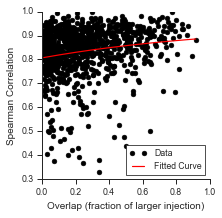

In [135]:
def exp(x, b, c, d):
    return d * 10**(-x / b) + c 

c_by_source.sort_values(by='fraction of match covered by td injection', inplace = True)
X = c_by_source['fraction of match covered by td injection'].values
y = c_by_source['spearman_correlation'].values
p0 = 1, 0.5, 0.1
popt_exp, pcov_exp = curve_fit(exp, X, y, p0)
print(popt_exp, pcov_exp)

fig, ax = plt.subplots(figsize = (3,3))
plt.plot(X, y, 'ko', label="Data")
plt.plot(X, exp(X, *popt_exp), 'r-', label="Fitted Curve")
plt.legend(loc = 4)
#ax.set_xlim([-0.01, 1])
sns.despine()
ax.tick_params(top = False, right = False)
ax.set_ylabel('Spearman Correlation', fontsize = 10)
ax.set_xlabel(r'Overlap (fraction of larger injection)', fontsize = 10)
#plt.savefig(os.path.join(path, 'inj size exponential fit.pdf'), 
#            bbox_inches='tight', pad_inches=0.3, format='pdf', dpi=300)

y_fit_exp = exp(X, *popt_exp)
# residual sum of squares
ss_res = np.sum((y - y_fit_exp) ** 2)

# total sum of squares
ss_tot = np.sum((y - np.mean(y)) ** 2)

# r-squared
r2 = 1 - (ss_res / ss_tot)
print(r2)
print(ss_res)

(array([0.00322718, 0.86712013]), array([[2.15377790e-07, 2.07938400e-06],
       [2.07938400e-06, 3.28464163e-05]]))


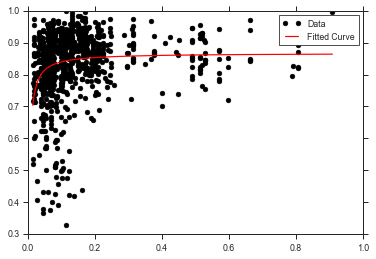

0.05950594984937796
9.714463580657918


In [136]:
def MM(x, k, c):
    return 1/(1+(k/x)) * c
c_by_source.sort_values(by='match_A_injection_size', inplace = True)
target_func = MM
X = c_by_source['match_A_injection_size'].values
y = c_by_source['spearman_correlation'].values
popt_MM, pcov_MM = curve_fit(MM, X, y)
print(popt_MM, pcov_MM)

plt.plot(X, y, 'ko', label="Data")
plt.plot(X, MM(X, *popt_MM), 'r-', label="Fitted Curve")
plt.legend()
plt.show()

y_fit_MM = MM(X, *popt_MM)
# residual sum of squares
ss_res = np.sum((y - y_fit_MM) ** 2)

# total sum of squares
ss_tot = np.sum((y - np.mean(y)) ** 2)

# r-squared
r2 = 1 - (ss_res / ss_tot)
print(r2)
print(ss_res)

In [137]:
def linear0(X, m, b):
    return m * X + b

def exp0(x, a, b, c):
    return a * 10**(-x / b) + c

z = c_by_source['log_inj_size']
x = c_by_source['match_A_injection_size'].values
Y = c_by_source['spearman_correlation'].values

popt_l, pcov_l = curve_fit(linear0, z, Y) # log inj size
popt_e, pcov_e = curve_fit(exp0, x, Y) # injection volume

yfitl=linear0(x, *popt_l)
yfite=exp0(x, *popt_e)

ssq1=((yfitl-Y)**2).sum()
ssq2=((yfite-Y)**2).sum()

n = len(x)    # number of data points
p = len(popt_e) # number of parameters

df = max(0, n-p) # number of degrees of freedom

f_ratio=(ssq1-ssq2)/(ssq2/df)
p=1-stats.f.cdf(f_ratio, 1, df)

print(f_ratio, p)
print(popt_l)
print(popt_e)

(742.4818577779279, 1.1102230246251565e-16)
[0.08072277 0.9123811 ]
[-0.13989161  0.17755289  0.87397594]


## Scheirer-Ray-Hare Test
This script performs the Scheirer-Ray-Hare Test on the exercise from 'Real Statistics Using Excel'

http://www.real-statistics.com/two-way-anova/scheirer-ray-hare-test/

Code copied from https://github.com/jpinzonc/Scheirer-Ray-Hare-Test/blob/master/Scheirer-Ray-Hare%20Test.ipynb

In [33]:
data = c_by_source[['match_A_injection_size', 'distance', 
               'fraction of match covered by td injection', 'spearman_correlation']]

In [34]:
data['rank'] = data['spearman_correlation'].sort_values().rank(numeric_only = float)

C:\Users\jenniferwh\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## Calculate sum of squares

In [35]:
rows = data.groupby(['match_A_injection_size'], as_index = False).agg({'rank':['count', 'mean', 'var']}).rename(columns={'rank':'row'})
rows.columns = ['_'.join(col) for col in rows.columns]
rows.columns = rows.columns.str.replace(r'_$',"")
rows['row_mean_rows'] = rows.row_mean.mean()
rows['sqdev'] = (rows.row_mean - rows.row_mean_rows)**2

In [36]:
rows.head()

,match_A_injection_size,row_count,row_mean,row_var,row_mean_rows,sqdev
0,0.013891,3,50.666667,1476.333333,455.376407,163789.974179
1,0.014786,2,264.500000,14620.500000,455.376407,36433.802871
2,0.016398,12,502.166667,80059.060606,455.376407,2189.328370
3,0.017168,7,166.714286,24367.238095,455.376407,83325.820449
4,0.019789,2,249.500000,85284.500000,455.376407,42385.095091


In [37]:
cols = data.groupby(['distance'], as_index = False).agg(
    {'rank':['count', 'mean', 'var']}).rename(columns={'rank':'col'})
cols.columns = ['_'.join(col) for col in cols.columns]
cols.columns = cols.columns.str.replace(r'_$',"")
cols['col_mean_cols'] = cols.col_mean.mean()
cols['sqdev'] = (cols.col_mean-cols.col_mean_cols)**2

In [38]:
cols.head()

,distance,col_count,col_mean,col_var,col_mean_cols,sqdev
0,0.000000,3,568.666667,85381.333333,447.890231,14586.947500
1,31.622777,1,217.000000,NaN,447.890231,53310.298603
2,37.416574,1,730.000000,NaN,447.890231,79585.921971
3,41.231056,2,474.500000,60.500000,447.890231,708.079826
4,43.588989,2,421.500000,9940.500000,447.890231,696.444273


In [39]:
data_sum         = data.groupby(['match_A_injection_size', 
                                 'distance'], 
                                as_index = False).agg({'rank':['count', 'mean', 'var']})
data_sum.columns = ['_'.join(col) for col in data_sum.columns]
data_sum.columns = data_sum.columns.str.replace(r'_$',"")

In [40]:
nobs_row   = rows.row_count.mean()
nobs_total = rows.row_count.sum()
nobs_col   = cols.col_count.mean()

In [41]:
Columns_SS = cols.sqdev.sum()*nobs_col
Rows_SS    = rows.sqdev.sum()*nobs_row
Within_SS  = data_sum.rank_var.sum()*(data_sum.rank_count.min()-1)
MS         = data['rank'].var()
TOTAL_SS   = MS * (nobs_total-1)
Inter_SS   = TOTAL_SS - Within_SS - Rows_SS - Columns_SS

## Calculating the H-statistics and degrees of freedom

In [42]:
H_rows = Rows_SS/MS
H_cols = Columns_SS/MS
H_int  = Inter_SS/MS
df_rows   = len(rows)-1
df_cols   = len(cols)-1
df_int    = df_rows*df_cols
df_total  = len(data)-1
df_within = df_total - df_int - df_cols - df_rows

## Calculating the p-values

In [43]:
p_rows  = 1.-stats.chi2.cdf(H_rows, df_rows)
p_cols  = 1-stats.chi2.cdf(H_cols, df_cols)
p_inter = 1-stats.chi2.cdf(H_int, df_int)

In [44]:
fdrcorr = sm.stats.fdrcorrection([p_rows, p_cols, p_inter], alpha=0.05, method='indep')
print(fdrcorr)
print(p_rows)
print(p_cols)
print(p_inter)

(array([ True,  True, False]), array([0.        , 0.02132865, 1.        ]))
0.0
0.01421910266632398
1.0


### with overlap instead of distance

In [45]:
rows = data.groupby(['match_A_injection_size'], as_index = False).agg({'rank':['count', 'mean', 'var']}).rename(columns={'rank':'row'})
rows.columns = ['_'.join(col) for col in rows.columns]
rows.columns = rows.columns.str.replace(r'_$',"")
rows['row_mean_rows'] = rows.row_mean.mean()
rows['sqdev'] = (rows.row_mean - rows.row_mean_rows)**2
cols = data.groupby(['fraction of match covered by td injection'], as_index = False).agg(
    {'rank':['count', 'mean', 'var']}).rename(columns={'rank':'col'})
cols.columns = ['_'.join(col) for col in cols.columns]
cols.columns = cols.columns.str.replace(r'_$',"")
cols['col_mean_cols'] = cols.col_mean.mean()
cols['sqdev'] = (cols.col_mean-cols.col_mean_cols)**2

In [46]:
data_sum         = data.groupby(['match_A_injection_size', 
                                 'fraction of match covered by td injection'], 
                                as_index = False).agg({'rank':['count', 'mean', 'var']})
data_sum.columns = ['_'.join(col) for col in data_sum.columns]
data_sum.columns = data_sum.columns.str.replace(r'_$',"")
nobs_row   = rows.row_count.mean()
nobs_total = rows.row_count.sum()
nobs_col   = cols.col_count.mean()
Columns_SS = cols.sqdev.sum()*nobs_col
Rows_SS    = rows.sqdev.sum()*nobs_row
Within_SS  = data_sum.rank_var.sum()*(data_sum.rank_count.min()-1)
MS         = data['rank'].var()
TOTAL_SS   = MS * (nobs_total-1)
Inter_SS   = TOTAL_SS - Within_SS - Rows_SS - Columns_SS
H_rows = Rows_SS/MS
H_cols = Columns_SS/MS
H_int  = Inter_SS/MS
df_rows   = len(rows)-1
df_cols   = len(cols)-1
df_int    = df_rows*df_cols
df_total  = len(data)-1
df_within = df_total - df_int - df_cols - df_rows
p_rows  = 1-stats.chi2.cdf(H_rows, df_rows)
p_cols  = 1-stats.chi2.cdf(H_cols, df_cols)
p_inter = 1-stats.chi2.cdf(H_int, df_int)
fdrcorr = sm.stats.fdrcorrection([p_rows, p_cols, p_inter], alpha=0.05, method='indep')
print(fdrcorr)

(array([ True, False, False]), array([0.        , 0.74062791, 1.        ]))


In [47]:
# size vs size and distance
def exp0(x, a, b, c):
    return a * 10**(-x / b) + c

def exp1(X, a, b, c, d):
    x,y = X
    return a * 10**(-x / b) + (c * y) + d

x = c_by_source['match_A_injection_size'].values
y = c_by_source['distance'].values
Y = c_by_source['spearman_correlation'].values

popt_0, pcov_0 = curve_fit(exp0, x, Y)
popt_1, pcov_1 = curve_fit(exp1, (x,y), Y)

yfit0=exp0(x, *popt_0)
yfit1=exp1((x,y), *popt_1)

ssq0=((yfit0-Y)**2).sum()
ssq1=((yfit1-Y)**2).sum()

n = len(x)    # number of data points
p = len(popt_1) # number of parameters

df = max(0, n-p) # number of degrees of freedom

f_ratio=(ssq0-ssq1)/(ssq1/df)
p=1-stats.f.cdf(f_ratio, 1, df)

print(f_ratio, p)
print(popt_1)
print(ssq0)
print(ssq1)

ss_res = np.sum((Y - yfit1) ** 2)

# total sum of squares
ss_tot = np.sum((Y - np.mean(Y)) ** 2)

# r-squared
r2 = 1 - (ss_res / ss_tot)
print(r2)

(23.5234822727096, 1.4527964847799169e-06)
[-1.34099128e-01  1.81409956e-01 -8.33959953e-05  9.12947351e-01]
9.545953669037871
9.30359168231423
0.09928401608617143


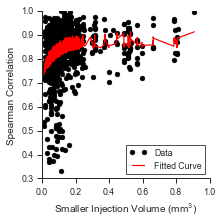

In [48]:
fig, ax = plt.subplots(figsize = (3,3))
plt.plot(x, Y, 'ko', label="Data")
plt.plot(x, exp1((x,y), *popt_1), 'r-', label="Fitted Curve")
plt.legend(loc = 4)
#ax.set_xlim([-0.01, 1])
sns.despine()
ax.tick_params(top = False, right = False)
ax.set_ylabel('Spearman Correlation', fontsize = 10)
ax.set_xlabel(r'Smaller Injection Volume (mm$\mathregular{^{3}}$)', fontsize = 10)
#plt.savefig(os.path.join(path, 'inj size exponential fit with distance.pdf'), 
#            bbox_inches='tight', pad_inches=0.3, format='pdf', dpi=300)

9.30359168231423
('ss total', 10.3291068977014)


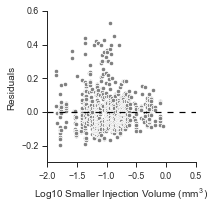

In [49]:
resids = (yfit1-Y)
fig, ax = plt.subplots(figsize = (3,3))
plt.scatter(c_by_source[['log_inj_size']], resids, c = 'gray')
plt.axhline(y=0, c='k', linestyle = '--')
sns.despine()
ax.tick_params(top = False, right = False)
ax.set_ylabel('Residuals', fontsize = 10)
ax.set_xlabel(r'Log10 Smaller Injection Volume (mm$\mathregular{^{3}}$)', fontsize = 10)
plt.tight_layout()
#plt.savefig(os.path.join(path, 'log inj size exp fit with distance residuals.pdf'), 
#            bbox_inches='tight', pad_inches=0.3, format='pdf', dpi=300)
print(np.sum(resids**2))
print('ss total', np.sum((Y - np.mean(Y)) ** 2))

In [50]:
# size vs size and overlap
def exp0(x, a, b, c):
    return a * 10**(-x / b) + c

def exp1(X, a, b, c, d):
    x,y = X
    return a * 10**(-x / b) + (c * y) + d

x = c_by_source['match_A_injection_size'].values
y = c_by_source['fraction of match covered by td injection'].values
Y = c_by_source['spearman_correlation'].values

popt_0, pcov_0 = curve_fit(exp0, x, Y)
popt_1, pcov_1 = curve_fit(exp1, (x,y), Y)

yfit0=exp0(x, *popt_0)
yfit1=exp1((x,y), *popt_1)

ssq0=((yfit0-Y)**2).sum()
ssq1=((yfit1-Y)**2).sum()

n = len(x)    # number of data points
p = len(popt_1) # number of parameters

df = max(0, n-p) # number of degrees of freedom

f_ratio=(ssq0-ssq1)/(ssq1/df)
p=1-stats.f.cdf(f_ratio, 1, df)

print(f_ratio, p)
print(popt_1)
print(ssq0)
print(ssq1)

ss_res = np.sum((Y - yfit1) ** 2)

# total sum of squares
ss_tot = np.sum((Y - np.mean(Y)) ** 2)

# r-squared
r2 = 1 - (ss_res / ss_tot)
print(r2)

(10.754494917552542, 0.0010800510302110267)
[-0.12528571  0.16987625  0.05683067  0.85344805]
9.545953669037871
9.433601925995422
0.08669723148138397


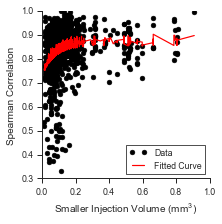

In [51]:
fig, ax = plt.subplots(figsize = (3,3))
plt.plot(x, Y, 'ko', label="Data")
plt.plot(x, exp1((x,y), *popt_1), 'r-', label="Fitted Curve")
plt.legend(loc = 4)
#ax.set_xlim([-0.01, 1])
sns.despine()
ax.tick_params(top = False, right = False)
ax.set_ylabel('Spearman Correlation', fontsize = 10)
ax.set_xlabel(r'Smaller Injection Volume (mm$\mathregular{^{3}}$)', fontsize = 10)
#plt.savefig(os.path.join(path, 'inj size exponential fit with overlap.pdf'), 
#            bbox_inches='tight', pad_inches=0.3, format='pdf', dpi=300)

In [52]:
# size and distance vs size and overlap
def exp1(X, a, b, c, d):
    x,y = X
    return a * 10**(-x / b) + (c * y) + d

x = c_by_source['match_A_injection_size'].values
y0 = c_by_source['distance'].values
y1 = c_by_source['fraction of match covered by td injection']
Y = c_by_source['spearman_correlation'].values

popt_0, pcov_0 = curve_fit(exp1, (x,y0), Y)
popt_1, pcov_1 = curve_fit(exp1, (x,y1), Y)

yfit0=exp1((x,y0), *popt_0)
yfit1=exp1((x,y1), *popt_1)

ssq0=((yfit0-Y)**2).sum()
ssq1=((yfit1-Y)**2).sum()

n = len(x)    # number of data points
p = len(popt_1) # number of parameters

df = max(0, n-p) # number of degrees of freedom

f_ratio=(ssq0-ssq1)/(ssq1/df)
p=1-stats.f.cdf(f_ratio, 1, df)

print(f_ratio, p)
print(popt_1)

ss_res = np.sum((Y - yfit1) ** 2)

# total sum of squares
ss_tot = np.sum((Y - np.mean(Y)) ** 2)

# r-squared
r2 = 1 - (ss_res / ss_tot)
print(r2)
print(ss_res)

(-12.444795844162972, 1.0)
[-0.12528571  0.16987625  0.05683067  0.85344805]
0.08669723148138397
9.433601925995422


You can use a permutation test.

Form your hypothesis as a full and reduced model test and using the original data compute the F-statistic for the full and reduced model test (or another stat of interest).

Now compute the fitted values and residuals for the reduced model, then randomly permute the residuals and add them back to the fitted values, now do the full and reduced test on the permuted dataset and save the F-statistic (or other). Repeate this many times (like 1999).

The p-value is then the proportion of the statistics that are greater than or equal to the original statistic.

This can be used to test interactions or groups of terms including interactions.

In [53]:
def exp0(x, a, b, c):
    return a * 10**(-x / b) + c

def exp1(X, a, b, c, d):
    x,y = X
    return a * 10**(-x / b) + (c * y) + d

x = c_by_source['match_A_injection_size'].values
y = c_by_source['distance'].values
Y = c_by_source['spearman_correlation'].values

popt_0, pcov_0 = curve_fit(exp0, x, Y)
popt_1, pcov_1 = curve_fit(exp1, (x,y), Y)

yfit0=exp0(x, *popt_0)
yfit_original=yfit0
yfit1=exp1((x,y), *popt_1)

resids0 = yfit0-Y

ssq0=((yfit0-Y)**2).sum()
ssq1=((yfit1-Y)**2).sum()

n = len(x)    # number of data points
p = len(popt_1) # number of parameters
df = max(0, n-p) # number of degrees of freedom

f_original=(ssq0-ssq1)/(ssq1/df)
p=1-stats.f.cdf(f_original, 1, df)
print(p)

f = []
p_values = []
for n in range(0, 2000):
    Y0 = yfit_original + np.random.permutation(resids0)
    popt_0, pcov_0 = curve_fit(exp0, x, Y0)
    popt_1, pcov_1 = curve_fit(exp1, (x,y), Y0)
    yfit0=exp0(x, *popt_0)
    yfit1=exp1((x,y), *popt_1)
    ssq0=((yfit0-Y0)**2).sum()
    ssq1=((yfit1-Y0)**2).sum()
    f_ratio=(ssq0-ssq1)/(ssq1/df)
    f.append(f_ratio)

print('p value for additional variable: ', len([value for value in f if value > f_original])/len(f))

1.4527964847799169e-06


C:\Users\jenniferwh\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in power
  
C:\Users\jenniferwh\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in power
  


('p value for additional variable: ', 0)


In [54]:
def exp0(x, a, b, c):
    return a * 10**(-x / b) + c

def exp1(X, a, b, c, d):
    x,y = X
    return a * 10**(-x / b) + (c * y) + d

x = c_by_source['match_A_injection_size'].values
y = c_by_source['injection_overlap'].values
Y = c_by_source['spearman_correlation'].values

popt_0, pcov_0 = curve_fit(exp0, x, Y)
popt_1, pcov_1 = curve_fit(exp1, (x,y), Y)

yfit0=exp0(x, *popt_0)
yfit_original=yfit0
yfit1=exp1((x,y), *popt_1)

resids0 = yfit0-Y

ssq0=((yfit0-Y)**2).sum()
ssq1=((yfit1-Y)**2).sum()

n = len(x)    # number of data points
p = len(popt_1) # number of parameters
df = max(0, n-p) # number of degrees of freedom

f_original=(ssq0-ssq1)/(ssq1/df)
p=1-stats.f.cdf(f_original, 1, df)
print(p)

f = []
p_values = []
for n in range(0, 2000):
    Y0 = yfit_original + np.random.permutation(resids0)
    popt_0, pcov_0 = curve_fit(exp0, x, Y0)
    popt_1, pcov_1 = curve_fit(exp1, (x,y), Y0)
    yfit0=exp0(x, *popt_0)
    yfit1=exp1((x,y), *popt_1)
    ssq0=((yfit0-Y0)**2).sum()
    ssq1=((yfit1-Y0)**2).sum()
    f_ratio=(ssq0-ssq1)/(ssq1/df)
    f.append(f_ratio)

print('p value for additional variable: ', len([value for value in f if value > f_original])/len(f))

6.461724330053542e-07


C:\Users\jenniferwh\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in power
  
C:\Users\jenniferwh\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in power
  


('p value for additional variable: ', 0)


## Pick the best model and compare with binning

In [138]:
def exp(X, a, b, c, d):
    x,y = X
    return a * 10**(-x / b) + (c * y) + d

x = c_by_source['match_A_injection_size'].values
y = c_by_source['distance'].values
Y = c_by_source['spearman_correlation'].values

popt, pcov = curve_fit(exp, (x,y), Y)
yfit=exp((x,y), *popt)

n = len(x)    # number of data points
p = len(popt) # number of parameters
df = max(0, n-p) # number of degrees of freedom

# residual sum of squares
ss_res = np.sum((Y - yfit) ** 2)

# total sum of squares
ss_tot = np.sum((Y - np.mean(Y)) ** 2)

# r-squared
r2 = 1 - (ss_res / ss_tot)
print(r2)
print(ss_res)
print(popt)

0.09928401624168293
9.303591680707937
[-1.34092987e-01  1.81441526e-01 -8.33962361e-05  9.12952064e-01]


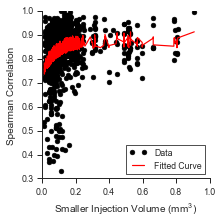

In [139]:
fig, ax = plt.subplots(figsize = (3,3))
plt.plot(x, Y, 'ko', label="Data")
plt.plot(x, exp((x,y), *popt), 'r-', label="Fitted Curve")
plt.legend(loc = 4)
#ax.set_xlim([-0.01, 1])
sns.despine()
ax.tick_params(top = False, right = False)
ax.set_ylabel('Spearman Correlation', fontsize = 10)
ax.set_xlabel(r'Smaller Injection Volume (mm$\mathregular{^{3}}$)', fontsize = 10)
#plt.savefig(os.path.join(path, 'inj size exponential fit with overlap.pdf'), 
#            bbox_inches='tight', pad_inches=0.3, format='pdf', dpi=300)

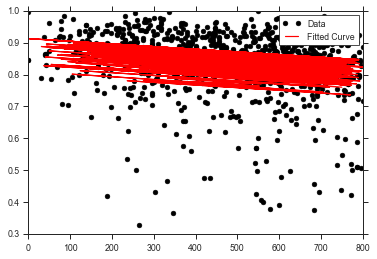

In [140]:
plt.plot(y, Y, 'ko', label="Data")
plt.plot(y, exp((x,y), *popt), 'r-', label="Fitted Curve")
plt.legend()
plt.show()

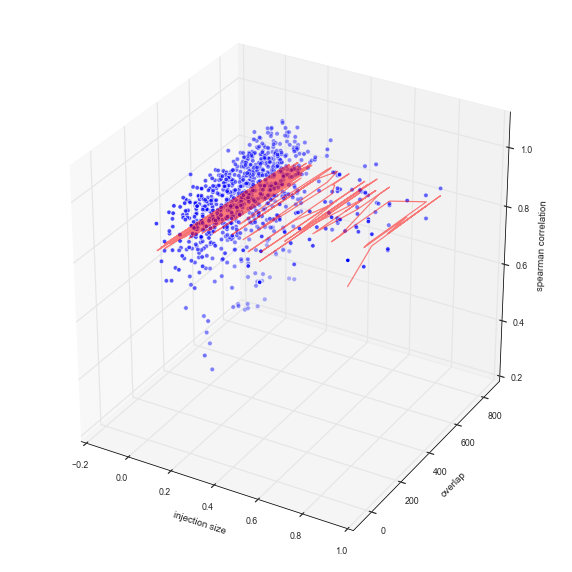

In [141]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, Y)
ax.plot(x, y, exp((x,y), *popt), 'r-', alpha = 0.5, label="Fitted Curve")
ax.set_xlabel('injection size')
ax.set_ylabel('overlap')
ax.set_zlabel('spearman correlation')

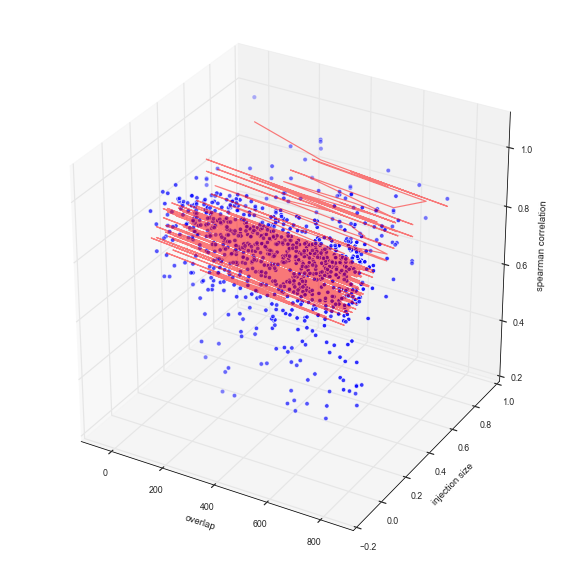

In [142]:
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(y, x, Y)
ax.plot(y, x, exp((x,y), *popt), 'r-', alpha = 0.5, label="Fitted Curve")
ax.set_xlabel('overlap')
ax.set_ylabel('injection size')
ax.set_zlabel('spearman correlation')

In [143]:
c_by_source['exp_predicted'] = exp((c_by_source['match_A_injection_size'].values,
                               c_by_source['distance'].values), *popt)

In [144]:
def predband(x, xd, yd, f_vars, conf=0.95):
    """
    Code adapted from Rodrigo Nemmen's post:
    http://astropython.blogspot.com.ar/2011/12/calculating-prediction-band-
    of-linear.html

    Calculates the prediction band of the regression model at the
    desired confidence level.

    Clarification of the difference between confidence and prediction bands:

    "The prediction bands are further from the best-fit line than the
    confidence bands, a lot further if you have many data points. The 95%
    prediction band is the area in which you expect 95% of all data points
    to fall. In contrast, the 95% confidence band is the area that has a
    95% chance of containing the true regression line."
    (from http://www.graphpad.com/guides/prism/6/curve-fitting/index.htm?
    reg_graphing_tips_linear_regressio.htm)

    Arguments:
    - x: array with x values to calculate the confidence band.
    - xd, yd: data arrays.
    - a, b, c: linear fit parameters.
    - conf: desired confidence level, by default 0.95 (2 sigma)

    References:
    1. http://www.JerryDallal.com/LHSP/slr.htm, Introduction to Simple Linear
    Regression, Gerard E. Dallal, Ph.D.
    """

    alpha = 1. - conf    # Significance
    N = len(xd) * len(xd[0])          # data sample size
    var_n = len(f_vars)  # Number of variables used by the fitted function.

    # Quantile of Student's t distribution for p=(1 - alpha/2)
    q = stats.t.ppf(1. - alpha / 2., N - var_n)

    # Std. deviation of an individual measurement (Bevington, eq. 6.15)
    se = np.sqrt(1. / (N - var_n) * np.sum((yd - exp(xd, *f_vars)) ** 2))

    # Auxiliary definitions
    sx = (x - xd[0].mean()) ** 2
    sxd = np.sum((xd[0] - xd[0].mean()) ** 2)

    # Predicted values (best-fit model)
    yp = exp(xd, *f_vars)
    # Prediction band
    dy = q * se * np.sqrt(1. + (1. / N) + (sx / sxd))

    # Upper & lower prediction bands.
    lpb, upb = yp - dy, yp + dy

    return lpb, upb

(0, 0.25)

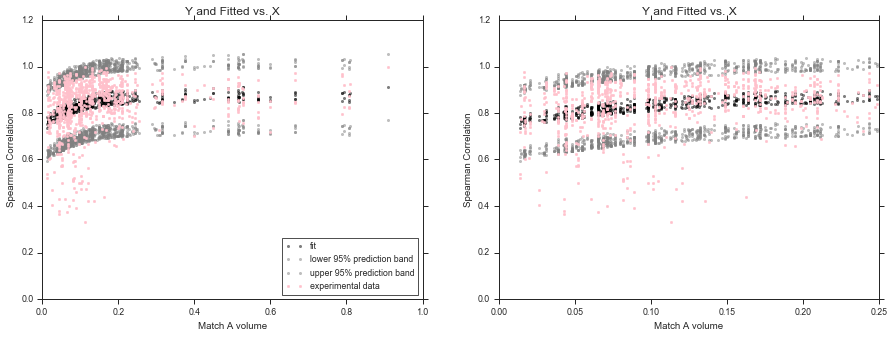

In [145]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
ax[0].plot(c_by_source['match_A_injection_size'].values, c_by_source['exp_predicted'].values, '.', color='k', 
        label='fit',
        alpha=.5)
ax[0].plot(c_by_source['match_A_injection_size'].values, predband(c_by_source['match_A_injection_size'].values,
                                                          (c_by_source['match_A_injection_size'].values, 
                                                          c_by_source['distance'].values), 
                                                          c_by_source['spearman_correlation'].values, popt)[0], 
        '.', color='gray', label='lower 95% prediction band',
        alpha=.5)
ax[0].plot(c_by_source['match_A_injection_size'].values, predband(c_by_source['match_A_injection_size'].values,
                                                          (c_by_source['match_A_injection_size'].values, 
                                                          c_by_source['distance'].values), 
                                                  c_by_source['spearman_correlation'].values, popt)[1], 
        '.', color='gray', label='upper 95% prediction band',
        alpha=.5)
ax[0].plot(c_by_source['match_A_injection_size'].values, c_by_source['spearman_correlation'].values, 
        '.', color='pink',
       label = 'experimental data')
ax[0].set_title('Y and Fitted vs. X', fontsize='large')
ax[0].set_xlabel('Match A volume')
ax[0].set_ylabel('Spearman Correlation')
ax[0].set_ylim([0, 1.2])
ax[0].legend(loc=4)

ax[1].plot(c_by_source['match_A_injection_size'].values, c_by_source['exp_predicted'].values, '.', color='k', 
        label='fit',
        alpha=.5)
ax[1].plot(c_by_source['match_A_injection_size'].values, predband(c_by_source['match_A_injection_size'].values,
                                                          (c_by_source['match_A_injection_size'].values, 
                                                          c_by_source['distance'].values), 
                                                          c_by_source['spearman_correlation'].values, popt)[0], 
        '.', color='gray', label='lower 95% prediction band',
        alpha=.5)
ax[1].plot(c_by_source['match_A_injection_size'].values, predband(c_by_source['match_A_injection_size'].values,
                                                          (c_by_source['match_A_injection_size'].values, 
                                                          c_by_source['distance'].values), 
                                                  c_by_source['spearman_correlation'].values, popt)[1], 
        '.', color='gray', label='upper 95% prediction band',
        alpha=.5)
ax[1].plot(c_by_source['match_A_injection_size'].values, c_by_source['spearman_correlation'].values, 
        '.', color='pink',
       label = 'experimental data')
ax[1].set_title('Y and Fitted vs. X', fontsize='large')
ax[1].set_xlabel('Match A volume')
ax[1].set_ylabel('Spearman Correlation')
ax[1].set_ylim([0, 1.2])
ax[1].set_xlim([0, 0.25])

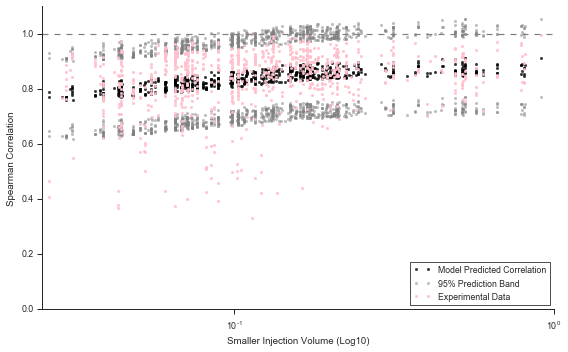

In [146]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.plot(c_by_source['match_A_injection_size'].values, c_by_source['exp_predicted'].values, '.', color='k', 
        label='Model Predicted Correlation',
        alpha=.8)
ax.plot(c_by_source['match_A_injection_size'].values, predband(c_by_source['match_A_injection_size'].values,
                                                          (c_by_source['match_A_injection_size'].values, 
                                                          c_by_source['distance'].values), 
                                                          c_by_source['spearman_correlation'].values, popt)[0], 
        '.', color='gray', label='95% Prediction Band',
        alpha=.5)
ax.plot(c_by_source['match_A_injection_size'].values, predband(c_by_source['match_A_injection_size'].values,
                                                          (c_by_source['match_A_injection_size'].values, 
                                                          c_by_source['distance'].values), 
                                                  c_by_source['spearman_correlation'].values, popt)[1], 
        '.', color='gray',
        alpha=.5)
ax.plot(c_by_source['match_A_injection_size'].values, c_by_source['spearman_correlation'].values, 
        '.', color='pink',
       label = 'Experimental Data')
ax.set_xlabel('Smaller Injection Volume (Log10)')
ax.set_ylabel('Spearman Correlation')
ax.set_xscale('log')
ax.set_xlim([0.025, 1])
ax.set_ylim([0, 1.1])
plt.axhline(y=1, color = 'gray', linestyle = '--')
ax.legend(loc=4)
sns.despine()
ax.tick_params(top=False, right=False)
ax.get_xaxis().set_tick_params(which='minor', size=0)
ax.get_xaxis().set_tick_params(which='minor', width=0) 
plt.tight_layout()
#plt.savefig(os.path.join(path, 'data with prediction bands.pdf'), 
#            bbox_inches='tight', pad_inches=0.3, format='pdf', dpi=300)

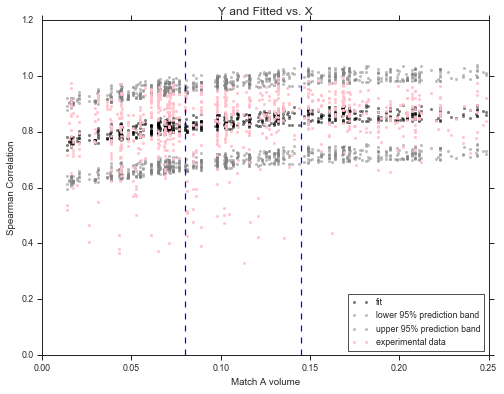

In [147]:
fig, ax = plt.subplots(figsize = (8, 6))
ax.plot(c_by_source['match_A_injection_size'].values, c_by_source['exp_predicted'].values, '.', color='k', 
        label='fit',
        alpha=.5)
ax.plot(c_by_source['match_A_injection_size'].values, predband(c_by_source['match_A_injection_size'].values,
                                                          (c_by_source['match_A_injection_size'].values, 
                                                          c_by_source['distance'].values), 
                                                          c_by_source['spearman_correlation'].values, popt)[0], 
        '.', color='gray', label='lower 95% prediction band',
        alpha=.5)
ax.plot(c_by_source['match_A_injection_size'].values, predband(c_by_source['match_A_injection_size'].values,
                                                          (c_by_source['match_A_injection_size'].values, 
                                                          c_by_source['distance'].values), 
                                                  c_by_source['spearman_correlation'].values, popt)[1], 
        '.', color='gray', label='upper 95% prediction band',
        alpha=.5)
ax.plot(c_by_source['match_A_injection_size'].values, c_by_source['spearman_correlation'].values, 
        '.', color='pink',
       label = 'experimental data')
ax.set_title('Y and Fitted vs. X', fontsize='large')
ax.set_xlabel('Match A volume')
ax.set_ylabel('Spearman Correlation')
ax.set_xlim([0, 0.25])
ax.set_ylim([0, 1.2])
ax.legend(loc=4)
plt.axvline(x=0.08, linestyle = '--')
plt.axvline(x=0.145, linestyle = '--')
#plt.axvline(x=0.27, linestyle = '--')

                             OLS Regression Results                             
Dep. Variable:     spearman_correlation   R-squared:                       0.037
Model:                              OLS   Adj. R-squared:                  0.031
Method:                   Least Squares   F-statistic:                     5.743
Date:                  Thu, 04 Apr 2019   Prob (F-statistic):            0.00357
Time:                          10:58:37   Log-Likelihood:                 280.92
No. Observations:                   299   AIC:                            -555.8
Df Residuals:                       296   BIC:                            -544.7
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const   

C:\Users\jenniferwh\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


                             OLS Regression Results                             
Dep. Variable:     spearman_correlation   R-squared:                       0.109
Model:                              OLS   Adj. R-squared:                  0.100
Method:                   Least Squares   F-statistic:                     11.71
Date:                  Thu, 04 Apr 2019   Prob (F-statistic):           1.60e-05
Time:                          10:58:38   Log-Likelihood:                 209.31
No. Observations:                   194   AIC:                            -412.6
Df Residuals:                       191   BIC:                            -402.8
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const   

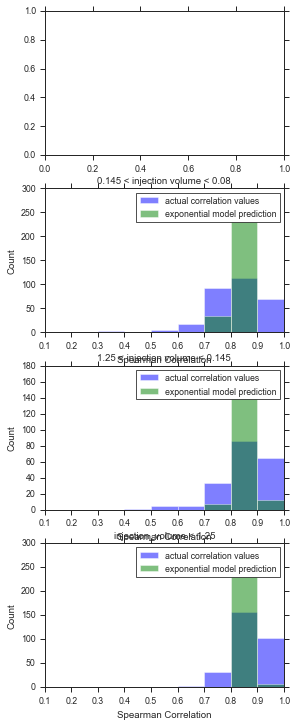

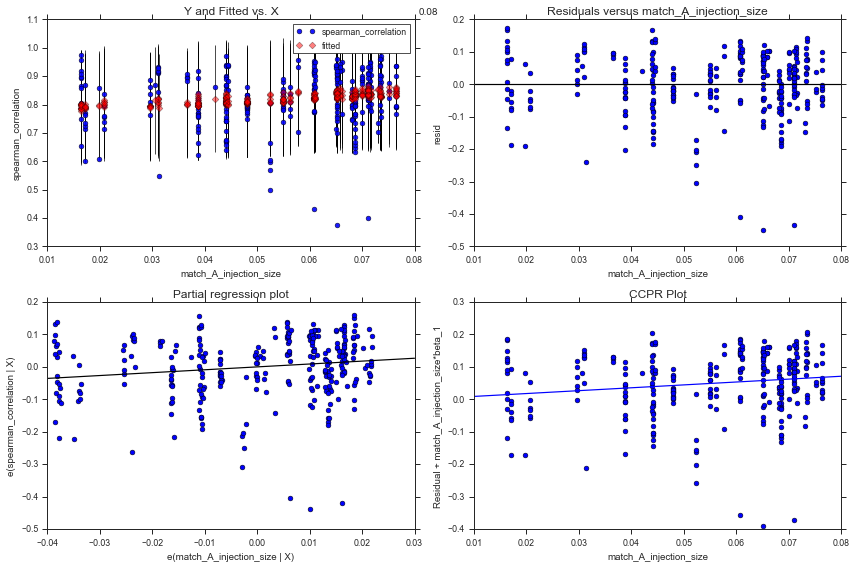

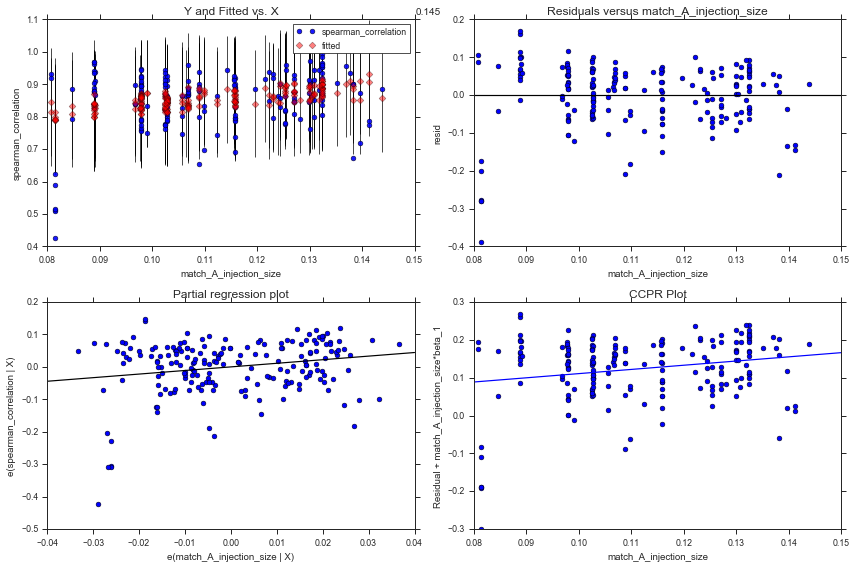

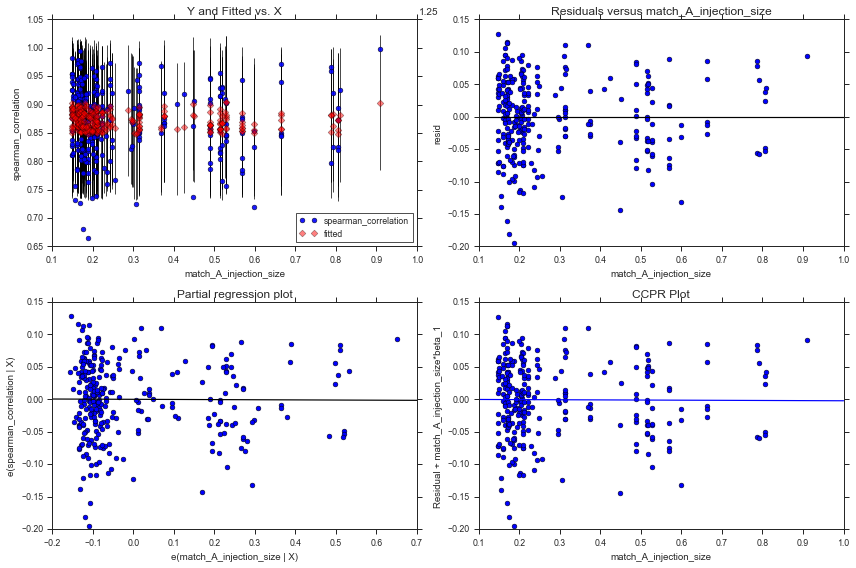

In [148]:
c_ctx['log_inj_size'] = np.log10(c_ctx['match_A_injection_size'])
size_bins = [0, 0.08, 0.145, 1.25]
fig, ax = plt.subplots(len(size_bins), figsize = (4, 10))
bins = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
for idx,threshold in enumerate(size_bins):
    dataset = c_ctx[(c_ctx['match_A_injection_size'] < threshold) &
                   (c_ctx['match_A_injection_size'] > size_bins[idx-1])]
    if len(dataset) > 0:
        X = dataset[['match_A_injection_size', 'distance']]
        X = sm.add_constant(X)
        y = dataset[['spearman_correlation']]

        # fit GLM
        fit = sm.OLS(y, X).fit()
        print(fit.summary())
        fig = plt.figure(figsize=(12,8))
        fig = sm.graphics.plot_regress_exog(fit, "match_A_injection_size", fig = fig)
        plt.suptitle(threshold)
        dataset['prediction'] = fit.predict(X)
        ax[idx].hist(dataset['spearman_correlation'].values, alpha = 0.5, bins = bins, 
                     label = 'actual correlation values');
        ax[idx].hist(dataset['prediction'].values, alpha = 0.5, bins = bins,
                     label = 'exponential model prediction')
        ax[idx].set_xlabel('Spearman Correlation')
        ax[idx].set_ylabel('Count')
        if idx < len(size_bins)-1:
            ax[idx].set_title('{0} < injection volume < {1}'.format(np.round(size_bins[idx+1], 3), 
                                                                    np.round(size_bins[idx], 3)))
        else:
            ax[idx].set_title('injection_volume < {0}'.format(size_bins[idx]))
    ax[idx].legend()
    plt.tight_layout()

In [149]:
c_by_source['prediction-actual_exp'] = c_by_source['exp_predicted'] - c_by_source['spearman_correlation']
c_by_source['prediction-actual_exp'].describe()

count    9.070000e+02
mean     1.849317e-09
std      1.013354e-01
min     -1.954658e-01
25%     -6.563751e-02
50%     -1.552833e-02
75%      3.850769e-02
max      5.295117e-01
Name: prediction-actual_exp, dtype: float64

In [153]:
dat = pd.DataFrame()
c_by_source['log_inj_size'] = np.log10(c_by_source['match_A_injection_size'])
size_bins = [0, 0.025, 0.095, 1.25]
for idx,threshold in enumerate(size_bins):
    dataset = c_by_source[(c_by_source['match_A_injection_size'] < threshold) &
                   (c_by_source['match_A_injection_size'] > size_bins[idx-1])]
    if len(dataset) > 0:
        X = dataset[['match_A_injection_size', 'distance']]
        X = sm.add_constant(X)
        y = dataset[['spearman_correlation']]

        # fit GLM
        fit = sm.OLS(y, X).fit()
        dataset['linear_prediction'] = fit.predict(X)
        dataset['bin'] = idx
        dat = dat.append(dataset)

C:\Users\jenniferwh\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\jenniferwh\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [154]:
dat.head()

,fraction of match covered by td injection,distance,source,spearman_correlation,pearson_correlation,absolute_overlap,match_A,injection_overlap,match_B,match_A_secondary_source,...,exp_predicted,prediction-actual_exp,linear_prediction_x,bin_x,prediction-actual_linear,low_pred_band,linear_prediction_y,bin_y,linear_prediction,bin
0,0.161675,571.751694,MD,0.717877,0.876016,3267.255076,183058837,0.954550,268076421,CL,...,0.752849,0.034972,0.761998,1,0.044121,0.661670,0.761330,1,0.761330,1
1,0.049606,236.643191,MD,0.536755,0.585410,700.294167,183058837,0.261109,168300739,CL,...,0.780796,0.244041,0.770940,1,0.234184,0.622261,0.784751,1,0.784751,1
2,0.053444,770.324607,MD,0.519426,0.451542,200.915903,183058837,0.250842,267607635,CL,...,0.736289,0.216863,0.770633,1,0.251207,0.621678,0.747452,1,0.747452,1
3,0.202843,458.148448,CA3,0.831041,0.924067,1783.045502,180523704,0.836589,272404772,CA2,...,0.763593,-0.067448,0.762588,1,-0.068453,0.656218,0.770942,1,0.770942,1
4,0.260941,415.451562,CA3,0.774526,0.869350,550.246083,180523704,0.647100,112745073,CA2,...,0.767153,-0.007373,0.757953,1,-0.016573,0.645449,0.773926,1,0.773926,1


In [155]:
c_by_source = c_by_source.merge(dat[['match_A', 'match_B', 'linear_prediction', 'bin']], 
                                on = ['match_A', 'match_B'], how = 'left')

In [156]:
c_by_source['prediction-actual_linear'] = c_by_source['linear_prediction'] - c_by_source['spearman_correlation']
c_by_source['prediction-actual_linear'].describe()

count    9.070000e+02
mean    -4.403216e-14
std      1.017613e-01
min     -1.879878e-01
25%     -6.512145e-02
50%     -1.642732e-02
75%      3.984437e-02
max      5.367168e-01
Name: prediction-actual_linear, dtype: float64

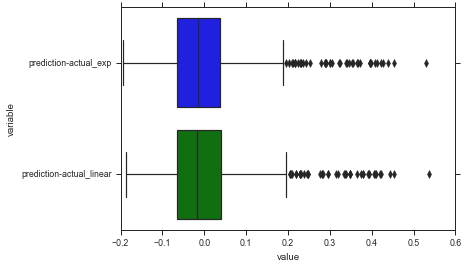

In [157]:
pltdat = c_by_source[['prediction-actual_exp', 'prediction-actual_linear']].melt()
sns.boxplot('value', 'variable', data = pltdat)

In [158]:
def predband(x, xd, yd, conf=0.95):
    """
    Code adapted from Rodrigo Nemmen's post:
    http://astropython.blogspot.com.ar/2011/12/calculating-prediction-band-
    of-linear.html

    Calculates the prediction band of the regression model at the
    desired confidence level.

    Clarification of the difference between confidence and prediction bands:

    "The prediction bands are further from the best-fit line than the
    confidence bands, a lot further if you have many data points. The 95%
    prediction band is the area in which you expect 95% of all data points
    to fall. In contrast, the 95% confidence band is the area that has a
    95% chance of containing the true regression line."
    (from http://www.graphpad.com/guides/prism/6/curve-fitting/index.htm?
    reg_graphing_tips_linear_regressio.htm)

    Arguments:
    - x: array with x values to calculate the confidence band.
    - xd, yd: data arrays.
    - a, b, c: linear fit parameters.
    - conf: desired confidence level, by default 0.95 (2 sigma)

    References:
    1. http://www.JerryDallal.com/LHSP/slr.htm, Introduction to Simple Linear
    Regression, Gerard E. Dallal, Ph.D.
    """

    alpha = 1. - conf    # Significance
    N = len(xd)        # data sample size
    var_n = 2  # Number of variables used by the fitted function.

    # Quantile of Student's t distribution for p=(1 - alpha/2)
    q = stats.t.ppf(1. - alpha / 2., N - var_n)
    
    # fit GLM
    xd = sm.add_constant(xd)
    fit = sm.OLS(yd, xd).fit()
    yp = fit.predict(xd)
    
    # Std. deviation of an individual measurement (Bevington, eq. 6.15)
    se = np.sqrt(1. / (N - var_n) * np.sum((yd - fit.predict(xd)) ** 2))

    # Auxiliary definitions
    sx = (x - xd['match_A_injection_size'].mean()) ** 2
    sxd = np.sum((xd['match_A_injection_size'] - xd['match_A_injection_size'].mean()) ** 2)

    # Predicted values (best-fit model)
    xd = sm.add_constant(xd)

    # Prediction band
    dy = q * se * np.sqrt(1. + (1. / N) + (sx / sxd))

    # Upper & lower prediction bands.
    lpb, upb = yp - dy, yp + dy

    return lpb, upb

(0, 0.25)

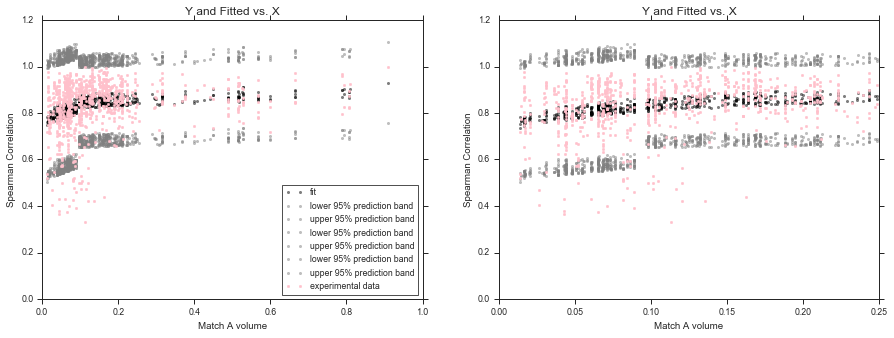

In [159]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
ax[0].plot(c_by_source['match_A_injection_size'].values, c_by_source['linear_prediction'].values, '.', color='k', 
        label='fit',
        alpha=.5)
ax[0].plot(c_by_source[c_by_source['bin'] == 1]['match_A_injection_size'].values, 
           predband(c_by_source[c_by_source['bin'] == 1]['match_A_injection_size'].values,
                    c_by_source[c_by_source['bin'] == 1][['match_A_injection_size', 
                                              'distance']], 
                    c_by_source[c_by_source['bin'] == 1]['spearman_correlation'].values)[0], 
        '.', color='gray', label='lower 95% prediction band',
        alpha=.5)
ax[0].plot(c_by_source[c_by_source['bin'] == 1]['match_A_injection_size'].values, 
           predband(c_by_source[c_by_source['bin'] == 1]['match_A_injection_size'].values,
                    c_by_source[c_by_source['bin'] == 1][['match_A_injection_size', 
                                              'distance']], 
                    c_by_source[c_by_source['bin'] == 1]['spearman_correlation'].values)[1], 
        '.', color='gray', label='upper 95% prediction band',
        alpha=.5)
ax[0].plot(c_by_source[c_by_source['bin'] == 2]['match_A_injection_size'].values, 
           predband(c_by_source[c_by_source['bin'] == 2]['match_A_injection_size'].values,
                    c_by_source[c_by_source['bin'] == 2][['match_A_injection_size', 
                                              'distance']], 
                    c_by_source[c_by_source['bin'] == 2]['spearman_correlation'].values)[0], 
        '.', color='gray', label='lower 95% prediction band',
        alpha=.5)
ax[0].plot(c_by_source[c_by_source['bin'] == 2]['match_A_injection_size'].values, 
           predband(c_by_source[c_by_source['bin'] == 2]['match_A_injection_size'].values,
                    c_by_source[c_by_source['bin'] == 2][['match_A_injection_size', 
                                              'distance']], 
                    c_by_source[c_by_source['bin'] == 2]['spearman_correlation'].values)[1], 
        '.', color='gray', label='upper 95% prediction band',
        alpha=.5)
ax[0].plot(c_by_source[c_by_source['bin'] == 3]['match_A_injection_size'].values, 
           predband(c_by_source[c_by_source['bin'] == 3]['match_A_injection_size'].values,
                    c_by_source[c_by_source['bin'] == 3][['match_A_injection_size', 
                                              'distance']], 
                    c_by_source[c_by_source['bin'] == 3]['spearman_correlation'].values)[0], 
        '.', color='gray', label='lower 95% prediction band',
        alpha=.5)
ax[0].plot(c_by_source[c_by_source['bin'] == 3]['match_A_injection_size'].values, 
           predband(c_by_source[c_by_source['bin'] == 3]['match_A_injection_size'].values,
                    c_by_source[c_by_source['bin'] == 3][['match_A_injection_size', 
                                              'distance']], 
                    c_by_source[c_by_source['bin'] == 3]['spearman_correlation'].values)[1], 
        '.', color='gray', label='upper 95% prediction band',
        alpha=.5)
ax[0].plot(c_by_source['match_A_injection_size'].values, c_by_source['spearman_correlation'].values, 
        '.', color='pink',
       label = 'experimental data')
ax[0].set_title('Y and Fitted vs. X', fontsize='large')
ax[0].set_xlabel('Match A volume')
ax[0].set_ylabel('Spearman Correlation')
ax[0].set_ylim([0, 1.2])
ax[0].legend(loc=4)

ax[1].plot(c_by_source['match_A_injection_size'].values, c_by_source['exp_predicted'].values, '.', color='k', 
        label='fit',
        alpha=.5)
ax[1].plot(c_by_source[c_by_source['bin'] == 1]['match_A_injection_size'].values, 
           predband(c_by_source[c_by_source['bin'] == 1]['match_A_injection_size'].values,
                    c_by_source[c_by_source['bin'] == 1][['match_A_injection_size', 
                                              'distance']], 
                    c_by_source[c_by_source['bin'] == 1]['spearman_correlation'].values)[0], 
        '.', color='gray', label='lower 95% prediction band',
        alpha=.5)
ax[1].plot(c_by_source[c_by_source['bin'] == 1]['match_A_injection_size'].values, 
           predband(c_by_source[c_by_source['bin'] == 1]['match_A_injection_size'].values,
                    c_by_source[c_by_source['bin'] == 1][['match_A_injection_size', 
                                              'distance']], 
                    c_by_source[c_by_source['bin'] == 1]['spearman_correlation'].values)[1], 
        '.', color='gray', label='upper 95% prediction band',
        alpha=.5)
ax[1].plot(c_by_source[c_by_source['bin'] == 2]['match_A_injection_size'].values, 
           predband(c_by_source[c_by_source['bin'] == 2]['match_A_injection_size'].values,
                    c_by_source[c_by_source['bin'] == 2][['match_A_injection_size', 
                                              'distance']], 
                    c_by_source[c_by_source['bin'] == 2]['spearman_correlation'].values)[0], 
        '.', color='gray', label='lower 95% prediction band',
        alpha=.5)
ax[1].plot(c_by_source[c_by_source['bin'] == 2]['match_A_injection_size'].values, 
           predband(c_by_source[c_by_source['bin'] == 2]['match_A_injection_size'].values,
                    c_by_source[c_by_source['bin'] == 2][['match_A_injection_size', 
                                              'distance']], 
                    c_by_source[c_by_source['bin'] == 2]['spearman_correlation'].values)[1], 
        '.', color='gray', label='upper 95% prediction band',
        alpha=.5)
ax[1].plot(c_by_source[c_by_source['bin'] == 3]['match_A_injection_size'].values, 
           predband(c_by_source[c_by_source['bin'] == 3]['match_A_injection_size'].values,
                    c_by_source[c_by_source['bin'] == 3][['match_A_injection_size', 
                                              'distance']], 
                    c_by_source[c_by_source['bin'] == 3]['spearman_correlation'].values)[0], 
        '.', color='gray', label='lower 95% prediction band',
        alpha=.5)
ax[1].plot(c_by_source[c_by_source['bin'] == 3]['match_A_injection_size'].values, 
           predband(c_by_source[c_by_source['bin'] == 3]['match_A_injection_size'].values,
                    c_by_source[c_by_source['bin'] == 3][['match_A_injection_size', 
                                              'distance']], 
                    c_by_source[c_by_source['bin'] == 3]['spearman_correlation'].values)[1], 
        '.', color='gray', label='upper 95% prediction band',
        alpha=.5)
ax[1].plot(c_by_source['match_A_injection_size'].values, c_by_source['spearman_correlation'].values, 
        '.', color='pink',
       label = 'experimental data')
ax[1].set_title('Y and Fitted vs. X', fontsize='large')
ax[1].set_xlabel('Match A volume')
ax[1].set_ylabel('Spearman Correlation')
ax[1].set_ylim([0, 1.2])
ax[1].set_xlim([0, 0.25])

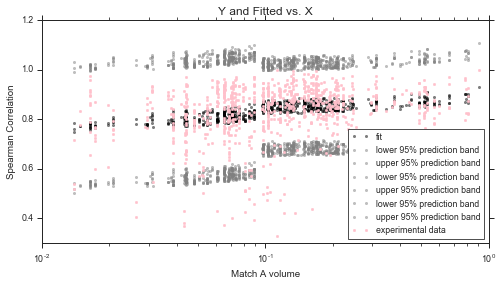

In [160]:
fig, ax = plt.subplots(figsize = (8, 4))
ax.plot(c_by_source['match_A_injection_size'].values, c_by_source['linear_prediction'].values, '.', color='k', 
        label='fit',
        alpha=.5)
ax.plot(c_by_source[c_by_source['bin'] == 1]['match_A_injection_size'].values, 
           predband(c_by_source[c_by_source['bin'] == 1]['match_A_injection_size'].values,
                    c_by_source[c_by_source['bin'] == 1][['match_A_injection_size', 
                                              'distance']], 
                    c_by_source[c_by_source['bin'] == 1]['spearman_correlation'].values)[0], 
        '.', color='gray', label='lower 95% prediction band',
        alpha=.5)
ax.plot(c_by_source[c_by_source['bin'] == 1]['match_A_injection_size'].values, 
           predband(c_by_source[c_by_source['bin'] == 1]['match_A_injection_size'].values,
                    c_by_source[c_by_source['bin'] == 1][['match_A_injection_size', 
                                              'distance']], 
                    c_by_source[c_by_source['bin'] == 1]['spearman_correlation'].values)[1], 
        '.', color='gray', label='upper 95% prediction band',
        alpha=.5)
ax.plot(c_by_source[c_by_source['bin'] == 2]['match_A_injection_size'].values, 
           predband(c_by_source[c_by_source['bin'] == 2]['match_A_injection_size'].values,
                    c_by_source[c_by_source['bin'] == 2][['match_A_injection_size', 
                                              'distance']], 
                    c_by_source[c_by_source['bin'] == 2]['spearman_correlation'].values)[0], 
        '.', color='gray', label='lower 95% prediction band',
        alpha=.5)
ax.plot(c_by_source[c_by_source['bin'] == 2]['match_A_injection_size'].values, 
           predband(c_by_source[c_by_source['bin'] == 2]['match_A_injection_size'].values,
                    c_by_source[c_by_source['bin'] == 2][['match_A_injection_size', 
                                              'distance']], 
                    c_by_source[c_by_source['bin'] == 2]['spearman_correlation'].values)[1], 
        '.', color='gray', label='upper 95% prediction band',
        alpha=.5)
ax.plot(c_by_source[c_by_source['bin'] == 3]['match_A_injection_size'].values, 
           predband(c_by_source[c_by_source['bin'] == 3]['match_A_injection_size'].values,
                    c_by_source[c_by_source['bin'] == 3][['match_A_injection_size', 
                                              'distance']], 
                    c_by_source[c_by_source['bin'] == 3]['spearman_correlation'].values)[0], 
        '.', color='gray', label='lower 95% prediction band',
        alpha=.5)
ax.plot(c_by_source[c_by_source['bin'] == 3]['match_A_injection_size'].values, 
           predband(c_by_source[c_by_source['bin'] == 3]['match_A_injection_size'].values,
                    c_by_source[c_by_source['bin'] == 3][['match_A_injection_size', 
                                              'distance']], 
                    c_by_source[c_by_source['bin'] == 3]['spearman_correlation'].values)[1], 
        '.', color='gray', label='upper 95% prediction band',
        alpha=.5)
ax.plot(c_by_source['match_A_injection_size'].values, c_by_source['spearman_correlation'].values, 
        '.', color='pink',
       label = 'experimental data')
ax.set_title('Y and Fitted vs. X', fontsize='large')
ax.set_xlabel('Match A volume')
ax.set_ylabel('Spearman Correlation')
ax.set_xscale('log')
ax.legend(loc=4)

## Back to the best model - binning was worse

In [161]:
def exp(X, a, b, c, d):
    x,y = X
    return a * 10**(-x / b) + (c * y) + d

x = c_by_source['match_A_injection_size'].values
y = c_by_source['distance'].values
Y = c_by_source['spearman_correlation'].values

popt, pcov = curve_fit(exp, (x,y), Y)
yfit=exp((x,y), *popt)

n = len(x)    # number of data points
p = len(popt) # number of parameters
df = max(0, n-p) # number of degrees of freedom

# residual sum of squares
ss_res = np.sum((Y - yfit) ** 2)

# total sum of squares
ss_tot = np.sum((Y - np.mean(Y)) ** 2)

# r-squared
r2 = 1 - (ss_res / ss_tot)
print(r2)
print(ss_res)
print(popt)

alpha = 0.05 # 95% confidence interval

n = len(Y)    # number of data points
p = len(popt) # number of parameters

dof = max(0, n-p) # number of degrees of freedom

tval = stats.t.ppf(1.0 - alpha / 2.0, dof) # student-t value for the dof and confidence level

lowparams = []
highparams = []
for i, p,var in zip(range(n), popt, np.diag(pcov)):
    sigma = var**0.5
    lowparams.append(p - sigma*tval)
    highparams.append(p + sigma*tval)
    print('c{0}: {1} [{2}  {3}]'.format(i, p,
                                  p - sigma*tval,
                                  p + sigma*tval))

0.09928401624168293
9.303591680707937
[-1.34092987e-01  1.81441526e-01 -8.33962361e-05  9.12952064e-01]
c0: -0.134092986837 [-0.170988393821  -0.0971975798537]
c1: 0.18144152637 [0.0819963434231  0.280886709316]
c2: -8.33962361355e-05 [-0.000117144708207  -4.96477640644e-05]
c3: 0.912952064211 [0.88871735074  0.937186777682]


In [162]:
print(lowparams)
print(highparams)

[-0.17098839382060557, 0.08199634342310583, -0.00011714470820666138, 0.8887173507396312]
[-0.09719757985372265, 0.28088670931626014, -4.9647764064399574e-05, 0.9371867776815771]


In [163]:
def predband(x, xd, yd, f_vars, conf=0.95):
    """
    Code adapted from Rodrigo Nemmen's post:
    http://astropython.blogspot.com.ar/2011/12/calculating-prediction-band-
    of-linear.html

    Calculates the prediction band of the regression model at the
    desired confidence level.

    Clarification of the difference between confidence and prediction bands:

    "The prediction bands are further from the best-fit line than the
    confidence bands, a lot further if you have many data points. The 95%
    prediction band is the area in which you expect 95% of all data points
    to fall. In contrast, the 95% confidence band is the area that has a
    95% chance of containing the true regression line."
    (from http://www.graphpad.com/guides/prism/6/curve-fitting/index.htm?
    reg_graphing_tips_linear_regressio.htm)

    Arguments:
    - x: array with x values to calculate the confidence band.
    - xd, yd: data arrays.
    - a, b, c: linear fit parameters.
    - conf: desired confidence level, by default 0.95 (2 sigma)

    References:
    1. http://www.JerryDallal.com/LHSP/slr.htm, Introduction to Simple Linear
    Regression, Gerard E. Dallal, Ph.D.
    """

    alpha = 1. - conf    # Significance
    N = len(xd) * len(xd[0])          # data sample size
    var_n = len(f_vars)  # Number of variables used by the fitted function.

    # Quantile of Student's t distribution for p=(1 - alpha/2)
    q = stats.t.ppf(1. - alpha / 2., N - var_n)

    # Std. deviation of an individual measurement (Bevington, eq. 6.15)
    se = np.sqrt(1. / (N - var_n) * np.sum((yd - exp(xd, *f_vars)) ** 2))

    # Auxiliary definitions
    sx = (x - xd[0].mean()) ** 2
    sxd = np.sum((xd[0] - xd[0].mean()) ** 2)

    # Predicted values (best-fit model)
    yp = exp(xd, *f_vars)
    # Prediction band
    dy = q * se * np.sqrt(1. + (1. / N) + (sx / sxd))

    # Upper & lower prediction bands.
    lpb, upb = yp - dy, yp + dy

    return lpb, upb

In [164]:
alldat['exp_predicted'] = exp((alldat['td_injection_size'].values,
                               alldat['distance'].values), *popt)

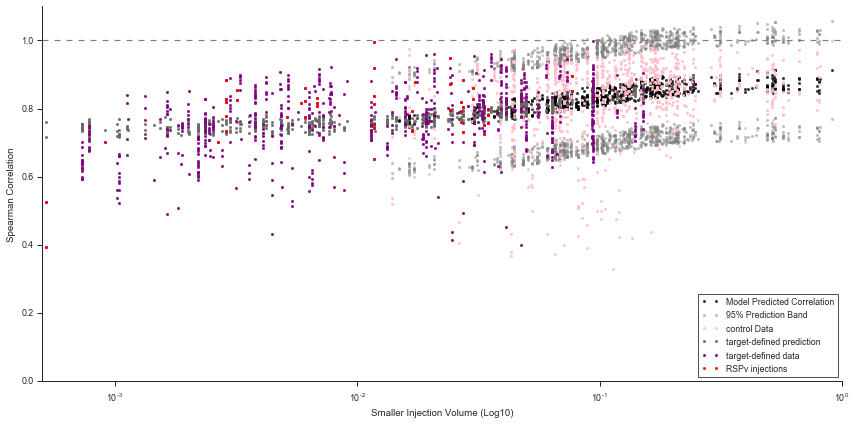

In [209]:
fig, ax = plt.subplots(figsize = (12, 6))
ax.plot(c_by_source['match_A_injection_size'].values, c_by_source['exp_predicted'].values, '.', color='k', 
        label='Model Predicted Correlation',
        alpha=.8)
ax.plot(c_by_source['match_A_injection_size'].values, predband(c_by_source['match_A_injection_size'].values,
                                                          (c_by_source['match_A_injection_size'].values, 
                                                          c_by_source['distance'].values), 
                                                          c_by_source['spearman_correlation'].values, popt)[0], 
        '.', color='gray', label='95% Prediction Band',
        alpha=.5)
ax.plot(c_by_source['match_A_injection_size'].values, predband(c_by_source['match_A_injection_size'].values,
                                                          (c_by_source['match_A_injection_size'].values, 
                                                          c_by_source['distance'].values), 
                                                  c_by_source['spearman_correlation'].values, popt)[1], 
        '.', color='gray',
        alpha=.5)
ax.plot(c_by_source['match_A_injection_size'].values, c_by_source['spearman_correlation'].values, 
        '.', color='pink',
       label = 'control Data')
ax.plot(alldat['td_injection_size'].values, alldat['exp_predicted'].values,
       '.', color = 'dimgray', label = 'target-defined prediction')
ax.plot(alldat['td_injection_size'].values, alldat['spearman_correlation'].values, 
       '.', color = 'purple', label = 'target-defined data')
ax.plot(alldat[alldat['source'] == 'RSPv']['td_injection_size'].values, 
        alldat[alldat['source'] == 'RSPv']['spearman_correlation'].values, 
       '.', color = 'red', label = 'RSPv injections')
ax.set_xlabel('Smaller Injection Volume (Log10)')
ax.set_ylabel('Spearman Correlation')
ax.set_xscale('log')
ax.set_xlim([0.0005, 1])
ax.set_ylim([0, 1.1])
plt.axhline(y=1, color = 'gray', linestyle = '--')
ax.legend(loc=4)
sns.despine()
ax.tick_params(top=False, right=False)
ax.get_xaxis().set_tick_params(which='minor', size=0)
ax.get_xaxis().set_tick_params(which='minor', width=0) 
plt.tight_layout()
#plt.savefig(os.path.join(path, 'data with prediction bands.pdf'), 
#            bbox_inches='tight', pad_inches=0.3, format='pdf', dpi=300)

In [200]:
alldat['low_pred_band'] = predband(alldat['td_injection_size'].values,
                              (alldat['td_injection_size'].values, 
                               alldat['distance'].values), 
                              alldat['spearman_correlation'].values, popt)[0]

In [201]:
print(len(alldat[alldat['spearman_correlation'] < alldat['low_pred_band']]))
print(len(alldat[alldat['spearman_correlation'] < alldat['low_pred_band']]['image_series_id'].unique()))
print(len(alldat))
alldat[alldat['spearman_correlation'] < alldat['low_pred_band']]['source'].unique()

78
33
791


array(['RE', 'VISp', 'VISl', 'ORBvl', 'MD', 'ORBm', 'ENTl', 'ILA', 'ENTm',
       'VISpl', 'RSPv', 'ORBl', 'AV', 'ACAv', 'RSPd'], dtype=object)

In [202]:
len(alldat[(alldat['source'] == 'RSPv') & (alldat['spearman_correlation'] < alldat['low_pred_band'])])

2

In [203]:
alldat[(alldat['source'] == 'RSPv') & (alldat['spearman_correlation'] < alldat['low_pred_band'])]

,pass/fail call,final call,same primary,same secondary for <50% primary,Secondaries >20% of other's primary,distance,injection_overlap,fraction of match covered by td injection,absolute_overlap,image_series_id,...,exclusion_zone_overlap,fraction of match covered by td exclusion zone,pearson_correlation,spearman_correlation,include,exp_predicted,low_pred_band,low_pred,predicted_spearman,exp_diff
1763,good,NaN,True,NaN,False,225.166605,0.421307,0.031516,14.693397,592522663,...,0.191553,0.336906,0.908320,0.527093,yes,0.760960,0.634434,0.720150,0.752982,0.225890
1765,0,NaN,True,NaN,False,747.930478,0.277582,0.020309,9.680884,592522663,...,0.487191,0.460513,0.503544,0.393040,yes,0.717363,0.590838,0.720167,0.744814,0.351774


In [204]:
c_by_source['low_pred_band'] = predband(c_by_source['match_A_injection_size'].values,
                              (c_by_source['match_A_injection_size'].values, 
                               c_by_source['distance'].values), 
                              c_by_source['spearman_correlation'].values, popt)[0]

In [205]:
c_by_source[c_by_source['spearman_correlation'] < c_by_source['low_pred_band']]['source'].unique()

array(['MD', 'VISp', 'VISpl', 'DG', 'AV', 'AM', 'SSp-bfd', 'ORBvl', 'RE',
       'SSp-m', 'VISl', 'ENTm', 'VISC'], dtype=object)

In [206]:
[source for source in c_by_source[c_by_source['spearman_correlation'] < c_by_source['low_pred_band']]['source'].unique() if source not in alldat['source'].unique()]

['DG', 'SSp-bfd', 'SSp-m', 'VISC']

In [207]:
alldat[alldat['spearman_correlation'] < alldat['low_pred_band']][[
    'source', 'image_series_id', 'spearman_correlation']]

,source,image_series_id,spearman_correlation
140,RE,496965687,0.590716
155,VISp,501711996,0.655846
161,VISp,501711996,0.683014
163,VISp,501711996,0.643878
166,VISp,501711996,0.680785
167,VISp,501711996,0.675984
168,VISp,501711996,0.691608
169,VISp,501711996,0.720322
170,VISp,501711996,0.701984
186,VISp,501711996,0.656553


In [174]:
float(len(alldat[alldat['spearman_correlation'] < alldat['low_pred_band']][[
    'source', 'image_series_id', 'spearman_correlation']]))/len(alldat)

0.0986093552465234

In [175]:
alldat['low_pred'] = exp((alldat['td_injection_size'].values, 
                        alldat['injection_overlap'].values), *lowparams)

In [176]:
len(alldat['source'].unique())

30

In [177]:
alldat[alldat['spearman_correlation'] < alldat['low_pred']]['source'].unique()

array(['AIv', 'ACAd', 'RSPv', 'VISam', 'ORBvl', 'ECT', 'VISp', 'RE',
       'VISl', 'ENTm', 'ENTl', 'MD', 'ORBm', 'ILA', 'ACAv', 'RSPd',
       'VISpl', 'ORBl', 'MOs', 'VISrl', 'RSPagl', 'PL', 'AM', 'SSp-tr',
       'AV'], dtype=object)

In [91]:
alldat[alldat['spearman_correlation'] < alldat['low_pred']]

,pass/fail call,final call,same primary,same secondary for <50% primary,Secondaries >20% of other's primary,distance,injection_overlap,fraction of match covered by td injection,absolute_overlap,image_series_id,...,transgenic_line,Virus,exclusion_zone_overlap,fraction of match covered by td exclusion zone,pearson_correlation,spearman_correlation,include,exp_predicted,low_pred_band,low_pred
12,good,include,True,NaN,False,402.740611,0.722608,0.593954,2328.883286,475829896,...,NaN,EGFP,0.620526,0.962614,0.962769,0.786334,yes,0.835659,0.705463,0.822567
13,ok,include,True,NaN,False,469.148164,0.667823,0.397343,2152.316659,475829896,...,NaN,EGFP,0.448290,0.626785,0.921473,0.774447,yes,0.832545,0.702349,0.821318
14,ok,NaN,True,NaN,False,687.095336,0.206041,0.174322,664.047681,475829896,...,Emx1-IRES-Cre,SypEGFP,0.273725,0.412064,0.877785,0.800823,yes,0.806302,0.676106,0.810790
15,ok,include,True,NaN,False,388.844442,0.862774,0.566458,2780.619760,475829896,...,Emx1-IRES-Cre,EGFP,0.619691,0.846465,0.697134,0.781031,yes,0.843624,0.713428,0.825762
16,ok,include,True,NaN,False,517.107339,0.765145,0.374319,2465.973054,475829896,...,Rbp4-Cre_KL100,EGFP,0.614792,0.660860,0.830236,0.809868,yes,0.838076,0.707880,0.823537
19,0,NaN,True,NaN,False,692.892488,0.015180,0.010053,48.924090,475829896,...,Emx1-IRES-Cre,EGFP,0.048817,0.067862,0.895915,0.803626,yes,0.795455,0.665259,0.806439
20,good,include,True,NaN,False,363.868108,0.850396,0.316369,1720.862250,475830603,...,NaN,EGFP,0.564044,0.623833,0.960904,0.780267,yes,0.823412,0.693255,0.799163
21,0,NaN,True,NaN,False,776.788259,0.076920,0.061227,155.654463,475830603,...,NaN,EGFP,0.107690,0.220994,0.959672,0.757807,yes,0.779455,0.649298,0.781529
22,ok,include,True,NaN,False,333.766385,0.908322,0.439152,1838.082391,475830603,...,Rbp4-Cre_KL100,EGFP,0.616005,0.841850,0.959604,0.799917,yes,0.826704,0.696547,0.800484
24,"ok, not great",include,True,NaN,False,507.838557,0.548474,0.374437,1109.891700,475830603,...,Emx1-IRES-Cre,EGFP,0.412646,0.783404,0.926635,0.782607,yes,0.806254,0.676097,0.792280


In [92]:
plot_order = ['ACAd', 'ACAv', 'PL', 'ILA', 'ORBl', 'ORBm', 'ORBvl', 
                'AIv',
              'RSPagl', 'RSPd', 'RSPv', 'VISa', 'VISam', 'VISpm', 
              'MOs', 'SSp-tr',
              'VISrl', 
              '', 
              'VISal', 'VISl', 'VISp', 'VISpl', 'VISli', 'VISpor',
             'SSs', 'SSp-bfd', 'SSp-ll', 'SSp-ul', 'SSp-n', 'SSp-m', 'MOp',
             'AUDd', 'AUDp', 'AUDpo',
             'VISC', 'ECT',
             'CA3', 'DG', 'SUB', 'ENTl', 'ENTm', 'AM', 'AV', 'MD', 'RE']

In [93]:
print([source for source in c_by_source['source'].unique() if source not in plot_order])
print([source for source in alldat['source'].unique() if source not in plot_order])

[]
[]


In [216]:
mcd = {'red': '#ff0000', 'orange': '#f9922b', 'yellow': '#ffff00', 'light_blue': '#90bff9',
      'dark_blue': '#5252a9', 'purple': '#7c429b', 'green': '#87d789'}

In [217]:
colors = [mcd['red'],mcd['red'],mcd['red'],mcd['red'],mcd['red'],mcd['red'],mcd['red'],
         mcd['yellow'],
         mcd['dark_blue'], mcd['dark_blue'], mcd['dark_blue'], mcd['dark_blue'], mcd['dark_blue'], 
          mcd['dark_blue'],
         mcd['orange'], mcd['orange'],
         mcd['light_blue'],
         '#000000',
         mcd['light_blue'],mcd['light_blue'],mcd['light_blue'],mcd['light_blue'],mcd['light_blue'],
          mcd['light_blue'],
         mcd['orange'],mcd['orange'],mcd['orange'],mcd['orange'],mcd['orange'],mcd['orange'],mcd['orange'],
         mcd['purple'],mcd['purple'],mcd['purple'],
         mcd['yellow'], mcd['yellow'],
         mcd['green'], mcd['green'], mcd['green'], mcd['green'], mcd['green'], 'k', 'k', 'k', 'k']

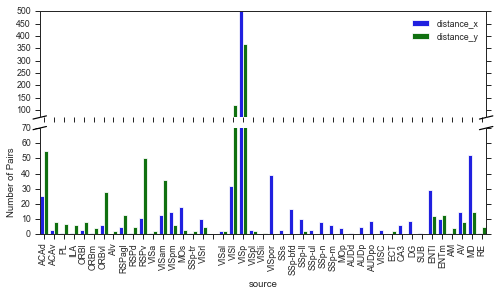

In [96]:
pltdat = c_by_source.groupby('source')['distance'].count().reset_index().merge(
    alldat.groupby('source')['distance'].count().reset_index()[[
        'source', 'distance']], on = 'source', how = 'outer') # just need a column to count, not actaually plotting correlation
pltdat = pltdat.melt(id_vars = 'source', var_name = 'Dataset', value_name = 'count')
f, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize = (8, 4))
    # plot the same data on both axes

sns.barplot('source', 'count', data = pltdat, ax = ax, hue = 'Dataset', order = plot_order)
sns.barplot('source', 'count', data = pltdat, ax = ax2, hue = 'Dataset', order = plot_order)

break_point = 70
ax.set_ylim(break_point, 500)  # top half
ax2.set_ylim(0, break_point)  # bottom half

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax.tick_params(labeltop='off')  # don't put tick labels at the top
ax.tick_params(top='off')
ax2.spines['top'].set_visible(False)
ax2.tick_params(top='off')
ax2.xaxis.tick_bottom()

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
f.subplots_adjust(hspace=0.1)
ax2.set_xlabel("source")
ax.set_xlabel("")
ax.set_ylabel("")
ax.legend(frameon = False)
ax2.legend_.remove()
plt.ylabel('Number of Pairs');
plt.setp( ax2.xaxis.get_majorticklabels(), rotation=90 );
#plt.savefig(os.path.join(path, 'number_of_pairs_in_datasets_by_source.png'))

In [97]:
c_by_source.loc[pd.isnull(c_by_source['transgenic_line_A']), 'transgenic_line_A'] = 'wt'
c_by_source.loc[pd.isnull(c_by_source['transgenic_line_B']), 'transgenic_line_B'] = 'wt'

In [98]:
VISp_matches = c_by_source[(c_by_source['source'] == 'VISp') &
            (c_by_source['match_A_percent_primary'] > 0.9) & 
            (c_by_source['match_B_percent_primary'] > 0.9)]

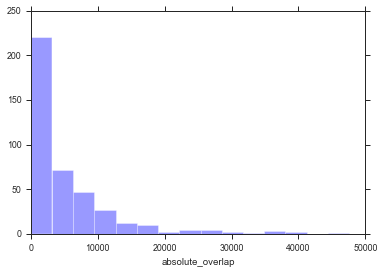

In [99]:
sns.distplot(VISp_matches['absolute_overlap'], kde = False, bins = 15)

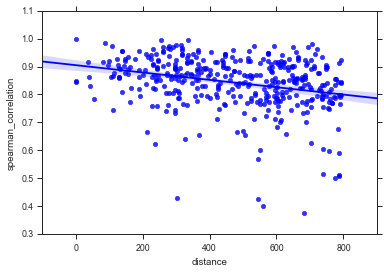

In [100]:
sns.regplot('distance', 'spearman_correlation', data = VISp_matches)

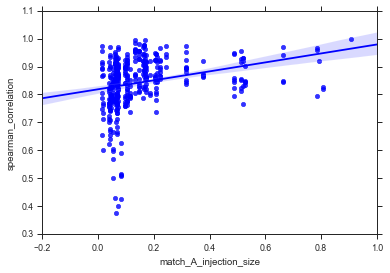

In [101]:
sns.regplot('match_A_injection_size', 'spearman_correlation', data = VISp_matches)

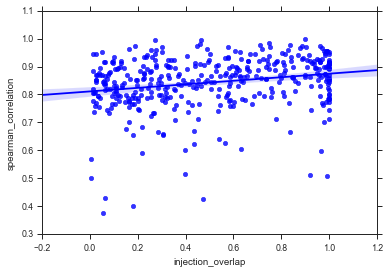

In [102]:
sns.regplot('injection_overlap', 'spearman_correlation', data = VISp_matches)

In [103]:
all_isids = np.unique(np.concatenate((VISp_matches['match_A'].unique(), 
                                      VISp_matches['match_B'].unique())))
print(len(all_isids))

isids = []
smaller_matches = []
larger_matches = []
injection_volumes = []
for isid in all_isids:
    dataset = VISp_matches[(VISp_matches['match_A'] == isid) | (VISp_matches['match_B'] == isid)]
    if len(dataset) > 1:
        if(len(VISp_matches[VISp_matches['match_A'] == isid]) > 0) and len(VISp_matches[VISp_matches['match_B'] == isid]) > 0:
            if(len(VISp_matches[VISp_matches['match_B'] == isid]['spearman_correlation']) < 
               len(VISp_matches[VISp_matches['match_A'] == isid]['spearman_correlation'])):
                for index in range(len(VISp_matches[VISp_matches['match_B'] == isid])):
                    for index2 in range(len(VISp_matches[VISp_matches['match_A'] == isid])):
                        isids.append(isid)
                        smaller_matches.append(
                            VISp_matches[VISp_matches['match_B'] == isid]['spearman_correlation'].values[index])
                        larger_matches.append(
                            VISp_matches[VISp_matches['match_A'] == isid]['spearman_correlation'].values[index2])
                        injection_volumes.append(VISp_matches[
                            VISp_matches['match_A'] == isid]['match_A_injection_size'].values[index2])
            elif(len(VISp_matches[VISp_matches['match_B'] == isid]['spearman_correlation']) < 
               len(VISp_matches[VISp_matches['match_A'] == isid]['spearman_correlation'])):
                for index in range(len(VISp_matches[VISp_matches['match_A'] == isid])):
                    for index2 in range(len(VISp_matches['match_B'] == isid)):
                        isids.append(isid)
                        smaller_matches.append(
                            VISp_matches[VISp_matches['match_A'] == isid]['spearman_correlation'].values[index])
                        larger_matches.append(
                            VISp_matches[VISp_matches['match_B'] == isid]['spearman_correlation'].values[index2])
                        injection_volumes.append(VISp_matches[
                            VISp_matches['match_A'] == isid]['match_A_injection_size'].values[index])
paired_matches = pd.DataFrame({'image_series_id': isids, 'paired with larger match': larger_matches,
                             'paired with smaller match': smaller_matches, 'injection_volume': injection_volumes})

46


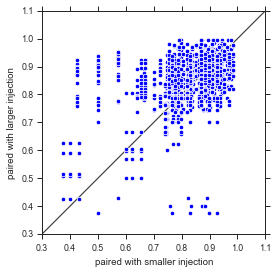

In [104]:
ax = sns.scatterplot('paired with smaller match', 'paired with larger match', 
                data = paired_matches, legend = False)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel('paired with smaller injection');
ax.set_ylabel('paired with larger injection');

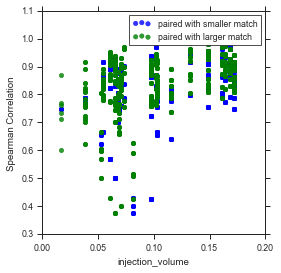

In [105]:
fig, ax = plt.subplots(figsize = (4, 4))
sns.regplot('injection_volume', 'paired with smaller match', data = paired_matches, 
            fit_reg = False, label = 'paired with smaller match')
sns.regplot('injection_volume', 'paired with larger match', data = paired_matches, 
            fit_reg = False, label = 'paired with larger match')
ax.set_ylabel('Spearman Correlation')
plt.legend()

In [106]:
all_isids = np.unique(np.concatenate((c_by_source['match_A'].unique(), c_by_source['match_B'].unique())))
num_comparisons = []
corr = []
predicted_corr = []
sources = []
inj_sizes = []
mean_ol = []
for isid in all_isids:
    if len(c_by_source[c_by_source['match_A'] == isid]['match_A_primary_source'].values) > 0:
        sources.append(c_by_source[c_by_source['match_A'] == isid]['match_A_primary_source'].values[0])
        inj_sizes.append(c_by_source[c_by_source['match_A'] == isid]['match_A_injection_size'].values[0])
    else:
        sources.append(c_by_source[c_by_source['match_B'] == isid]['match_B_primary_source'].values[0])
        inj_sizes.append(c_by_source[c_by_source['match_B'] == isid]['match_A_injection_size'].values[0])
    dataset = c_by_source[(c_by_source['match_A'] == isid) | (c_by_source['match_B'] == isid)]
    num_comparisons.append(len(dataset))
    corr.append(dataset['spearman_correlation'].mean())
    predicted_corr.append(dataset['exp_predicted'].mean())
    mean_ol.append(dataset['injection_overlap'].mean())

In [107]:
cmeans = pd.DataFrame({'image_series_id': all_isids, 'source': sources, 
                       'injection_size': inj_sizes, 'number of comparisons': num_comparisons, 
                       'spearman_correlation': corr, 'predicted_spearman': predicted_corr,
                      'mean_overlap': mean_ol})
print(len(cmeans))

296


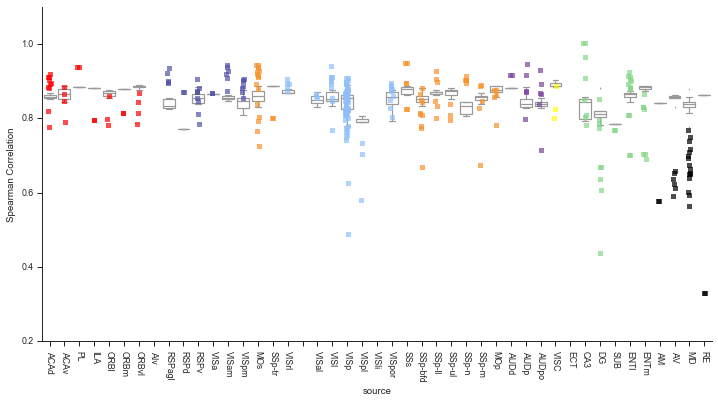

In [220]:
fig, ax = plt.subplots(figsize = (12, 6))
sns.boxplot('source', 'predicted_spearman', data = cmeans, 
            color = 'white', order = plot_order, fliersize = 1)
sns.stripplot('source', 'spearman_correlation', data = cmeans, 
              alpha = 0.7, marker = 's', order = plot_order, palette = colors)
#sns.stripplot('source', 'Delta Correlation', data = alldat, order = plot_order)
plt.xticks(rotation = -90);
ax.tick_params(right=False, top=False)
sns.despine()
#ax.set_ylim([0.6, 1]);
ax.set_ylabel('Spearman Correlation')
#plt.savefig(os.path.join(path, 'model correlation by source controls.png'), 
#            bbox_inches='tight', pad_inches=0.3, format='png', dpi=300)

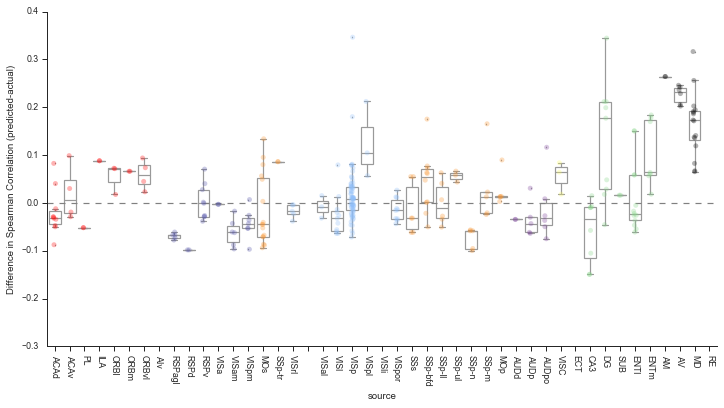

In [109]:
cmeans['Difference in Spearman Correlation'] = cmeans['predicted_spearman'] - cmeans['spearman_correlation']
fig, ax = plt.subplots(figsize = (12, 6))
sns.boxplot('source', 'Difference in Spearman Correlation', data = cmeans, 
            color = 'white', order = plot_order, fliersize = 1)
sns.stripplot('source', 'Difference in Spearman Correlation', data = cmeans, 
              alpha = 0.3, order = plot_order, palette = colors)
#sns.stripplot('source', 'Delta Correlation', data = alldat, order = plot_order)
plt.xticks(rotation = -90);
ax.tick_params(right=False, top=False)
sns.despine()
plt.axhline(y=0, color='gray', linestyle = '--')
ax.set_ylim([-0.3, 0.4]);
ax.set_ylabel('Difference in Spearman Correlation (predicted-actual)')

In [110]:
alldat['predicted_spearman'] = exp((alldat['td_injection_size'].values,
                               alldat['injection_overlap'].values), *popt)
alldat['exp_diff'] = alldat['predicted_spearman'] - alldat['spearman_correlation']

In [111]:
alldat.keys()

Index([u'pass/fail call', u'final call', u'same primary',
       u'same secondary for <50% primary',
       u'Secondaries >20% of other's primary', u'distance',
       u'injection_overlap', u'fraction of match covered by td injection',
       u'absolute_overlap', u'image_series_id', u'source',
       u'td_percent_primary', u'td_secondary_source', u'td_percent_secondary',
       u'match_id', u'match_primary_source', u'match_percent_primary',
       u'match_secondary_source', u'match_percent_secondary', u'comments',
       u'Julie's call', u'td_injection_size', u'match_injection_size',
       u'injection_size_ratio', u'transgenic_line', u'Virus',
       u'exclusion_zone_overlap',
       u'fraction of match covered by td exclusion zone',
       u'pearson_correlation', u'spearman_correlation', u'include',
       u'exp_predicted', u'low_pred_band', u'low_pred', u'predicted_spearman',
       u'exp_diff'],
      dtype='object')

In [112]:
meandat = alldat.groupby('image_series_id')[['spearman_correlation', 
                                             'predicted_spearman',
                                             'exp_diff']].mean().reset_index()
meandat['number of comparisons'] = alldat.groupby('image_series_id')['match_id'].count().values
for isid in meandat['image_series_id']:
    dataset = alldat[alldat['image_series_id'] == isid]
    meandat.loc[meandat['image_series_id'] == isid, 'source'] = alldat[
        alldat['image_series_id'] == isid]['source'].unique()[0]
    meandat.loc[meandat['image_series_id'] == isid, 'injection_size'] = alldat[
        alldat['image_series_id'] == isid]['td_injection_size'].unique()[0]
    meandat.loc[meandat['image_series_id'] == isid, 'mean_overlap'] = alldat[
        alldat['image_series_id'] == isid]['injection_overlap'].mean()

In [113]:
len(meandat)

138

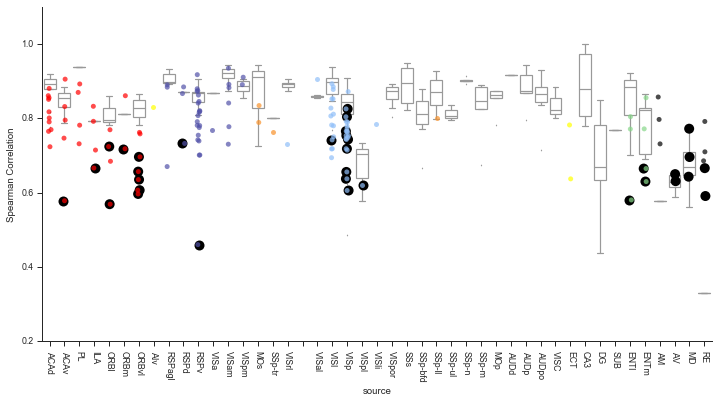

In [223]:
fig, ax = plt.subplots(figsize = (12, 6))
sns.boxplot('source', 'spearman_correlation', data = cmeans, 
            color = 'white', order = plot_order, fliersize = 1)
sns.stripplot('source', 'spearman_correlation', 
              data = meandat[meandat['image_series_id'].isin(
                  alldat[alldat['spearman_correlation'] < alldat['low_pred_band']]['image_series_id'])], 
              order = plot_order, s = 10, marker = 'o', color = 'k')
sns.stripplot('source', 'spearman_correlation', data = meandat, 
              alpha = 0.7, order = plot_order, palette = colors)
#sns.stripplot('source', 'Delta Correlation', data = alldat, order = plot_order)
plt.xticks(rotation = -90);
ax.tick_params(top=False, right=False)
sns.despine()
#ax.set_ylim([0.6, 1]);
ax.set_ylabel('Spearman Correlation')
#ax.axhline(y=0, c='gray', linestyle = '--')
plt.savefig(os.path.join(path, 'model correlation by source td with control boxplots.png'), 
            bbox_inches='tight', pad_inches=0.3, format='png', dpi=300)

In [115]:
meandat[(meandat['source'] == 'RSPv') & (meandat['spearman_correlation'] < 0.6)]

,image_series_id,spearman_correlation,predicted_spearman,exp_diff,number of comparisons,source,injection_size,mean_overlap
102,592522663,0.460067,0.748898,0.288832,2,RSPv,0.000518,0.349445


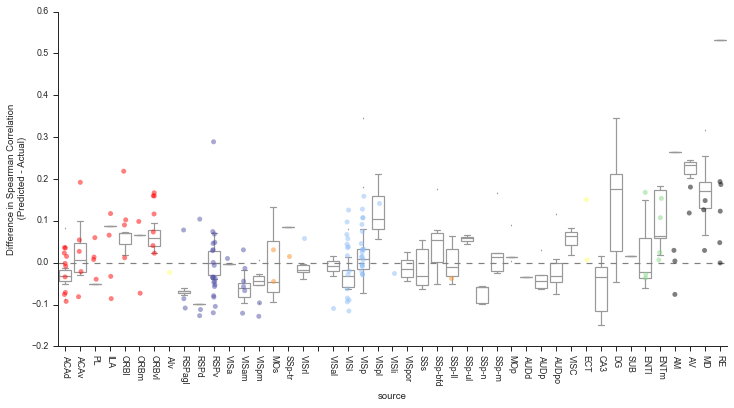

In [116]:
fig, ax = plt.subplots(figsize = (12, 6))
sns.boxplot('source', 'Difference in Spearman Correlation', data = cmeans, 
            color = 'white', order = plot_order, fliersize = 1)
sns.stripplot('source', 'exp_diff', data = meandat, 
              alpha = 0.5, order = plot_order, palette = colors)
#sns.stripplot('source', 'Delta Correlation', data = alldat, order = plot_order)
plt.xticks(rotation = -90);
sns.despine()
ax.tick_params(top=False, right=False)
#ax.set_ylim([-0.7, 0.3]);
ax.set_ylabel('Difference in Spearman Correlation\n (Predicted - Actual)')
ax.axhline(y=0, c='gray', linestyle = '--')
#plt.savefig(os.path.join(path, 'correlation difference by source controls.png'), 
#            bbox_inches='tight', pad_inches=0.3, format='png', dpi=300)

(-0.0002296668055721518, 0.2964937670089017)


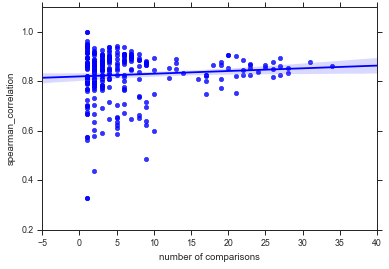

In [117]:
sns.regplot('number of comparisons', 'spearman_correlation', data = cmeans)
slope, intercept, r_value, p_value, std_error = stats.linregress(
            cmeans['number of comparisons'], 
            cmeans['predicted_spearman'])
print(slope, p_value)

(0.000378119863549638, 0.7537115488300152)


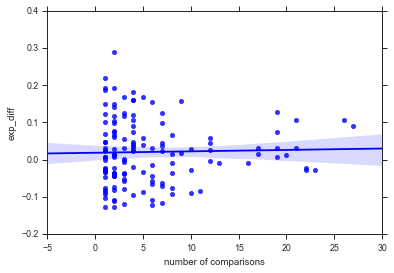

In [118]:
sns.regplot('number of comparisons', 'exp_diff', data = meandat)
slope, intercept, r_value, p_value, std_error = stats.linregress(
            meandat['number of comparisons'], 
            meandat['exp_diff'])
print(slope, p_value)

In [119]:
sub_alldat = alldat.sort_values(by='td_injection_size')[:len(c_by_source)]

In [120]:
A = c_by_source[['match_A_injection_size', 'injection_overlap', 'spearman_correlation', 'exp_predicted']]
B = alldat[['td_injection_size', 'injection_overlap', 'spearman_correlation', 'exp_predicted']]
B.rename(columns = {'td_injection_size': 'match_A_injection_size'}, inplace = True)
both = pd.concat([A,B])

C:\Users\jenniferwh\AppData\Local\Continuum\anaconda2\lib\site-packages\pandas\core\frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [121]:
both.head()

,match_A_injection_size,injection_overlap,spearman_correlation,exp_predicted
0,0.013891,0.261109,0.536755,0.764503
1,0.013891,0.954550,0.717877,0.803912
2,0.013891,0.250842,0.519426,0.763919
3,0.014786,0.836589,0.831041,0.798459
4,0.014786,0.647100,0.774526,0.787690


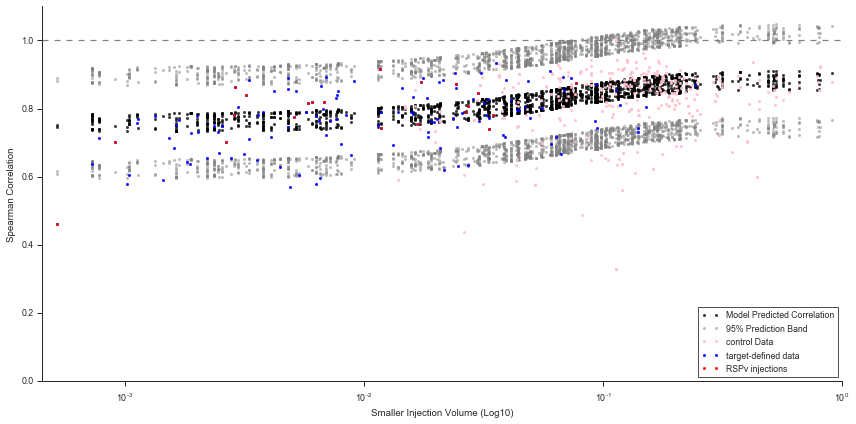

In [122]:
fig, ax = plt.subplots(figsize = (12, 6))
ax.plot(both['match_A_injection_size'].values, both['exp_predicted'].values, '.', color='k', 
        label='Model Predicted Correlation',
        alpha=.8)
ax.plot(both['match_A_injection_size'].values, predband(both['match_A_injection_size'].values,
                                                          (both['match_A_injection_size'].values, 
                                                          both['injection_overlap'].values), 
                                                          both['spearman_correlation'].values, popt)[0], 
        '.', color='gray', label='95% Prediction Band',
        alpha=.5)
ax.plot(both['match_A_injection_size'].values, predband(both['match_A_injection_size'].values,
                                                          (both['match_A_injection_size'].values, 
                                                          both['injection_overlap'].values), 
                                                  both['spearman_correlation'].values, popt)[1], 
        '.', color='gray',
        alpha=.5)
ax.plot(cmeans['injection_size'].values, cmeans['spearman_correlation'].values, 
        '.', color='pink',
       label = 'control Data')
ax.plot(meandat['injection_size'].values, meandat['spearman_correlation'].values,
       '.', color = 'b', label = 'target-defined data')
ax.plot(meandat[meandat['source'] == 'RSPv']['injection_size'].values, 
        meandat[meandat['source'] == 'RSPv']['spearman_correlation'].values, 
       '.', color = 'red', label = 'RSPv injections')
ax.set_xlabel('Smaller Injection Volume (Log10)')
ax.set_ylabel('Spearman Correlation')
ax.set_xscale('log')
ax.set_xlim([0.00045, 1])
ax.set_ylim([0, 1.1])
plt.axhline(y=1, color = 'gray', linestyle = '--')
ax.legend(loc=4)
sns.despine()
ax.tick_params(top=False, right=False)
ax.get_xaxis().set_tick_params(which='minor', size=0)
ax.get_xaxis().set_tick_params(which='minor', width=0) 
plt.tight_layout()

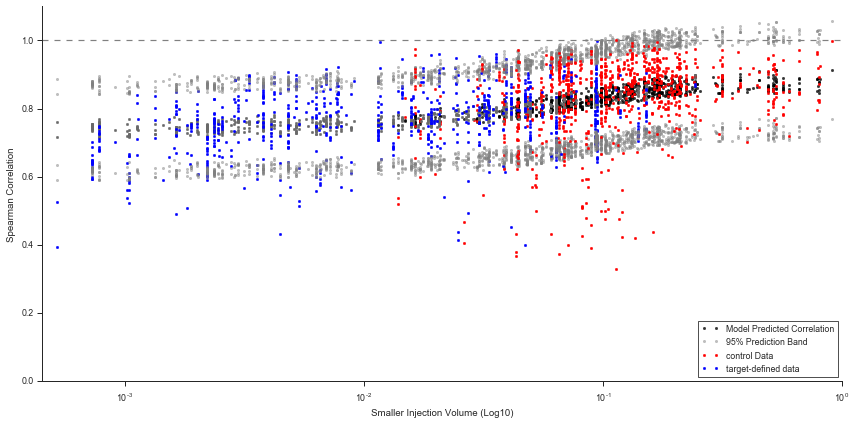

In [215]:
fig, ax = plt.subplots(figsize = (12, 6))
ax.plot(c_by_source['match_A_injection_size'].values, c_by_source['exp_predicted'].values, '.', color='k', 
        label='Model Predicted Correlation',
        alpha=.8)
ax.plot(c_by_source['match_A_injection_size'].values, predband(c_by_source['match_A_injection_size'].values,
                                                          (c_by_source['match_A_injection_size'].values, 
                                                          c_by_source['distance'].values), 
                                                          c_by_source['spearman_correlation'].values, popt)[0], 
        '.', color='gray', label='95% Prediction Band',
        alpha=.5)
ax.plot(c_by_source['match_A_injection_size'].values, predband(c_by_source['match_A_injection_size'].values,
                                                          (c_by_source['match_A_injection_size'].values, 
                                                          c_by_source['distance'].values), 
                                                  c_by_source['spearman_correlation'].values, popt)[1], 
        '.', color='gray',
        alpha=.5)
ax.plot(c_by_source['match_A_injection_size'].values, c_by_source['spearman_correlation'].values, 
        '.', color='red',
       label = 'control Data')
ax.plot(alldat['td_injection_size'].values, alldat['exp_predicted'].values,
       '.', color = 'dimgray')
ax.plot(alldat['td_injection_size'].values, alldat['spearman_correlation'].values, 
       '.', color = 'b', label = 'target-defined data')
ax.plot(alldat['td_injection_size'].values, predband(alldat['td_injection_size'].values,
                                                          (alldat['td_injection_size'].values, 
                                                          alldat['distance'].values), 
                                                          alldat['spearman_correlation'].values, popt)[0], 
        '.', color='gray',
        alpha=.5)
ax.plot(alldat['td_injection_size'].values, predband(alldat['td_injection_size'].values,
                                                          (alldat['td_injection_size'].values, 
                                                          alldat['distance'].values), 
                                                  alldat['spearman_correlation'].values, popt)[1], 
        '.', color='gray',
        alpha=.5)
'''
ax.plot(alldat[alldat['source'] == 'RSPv']['td_injection_size'].values, 
        alldat[alldat['source'] == 'RSPv']['spearman_correlation'].values, 
       '.', color = 'blue', label = 'RSPv injections')
       '''
ax.set_xlabel('Smaller Injection Volume (Log10)')
ax.set_ylabel('Spearman Correlation')
ax.set_xscale('log')
ax.set_xlim([0.00045, 1])
ax.set_ylim([0, 1.1])
plt.axhline(y=1, color = 'gray', linestyle = '--')
ax.legend(loc=4)
sns.despine()
ax.tick_params(top=False, right=False)
ax.get_xaxis().set_tick_params(which='minor', size=0)
ax.get_xaxis().set_tick_params(which='minor', width=0) 
plt.tight_layout()
plt.savefig(os.path.join(path, 'wt and td with prediction bands.pdf'), 
            bbox_inches='tight', pad_inches=0.3, format='pdf', dpi=300)

In [212]:
meandat.keys()

Index([u'image_series_id', u'spearman_correlation', u'predicted_spearman',
       u'exp_diff', u'number of comparisons', u'source', u'injection_size',
       u'mean_overlap', u'low_pred_band'],
      dtype='object')

In [213]:
A = cmeans[['injection_size', 'mean_overlap', 'spearman_correlation', 'predicted_spearman']]
B = meandat[['injection_size', 'mean_overlap', 'spearman_correlation', 'predicted_spearman']]
both = pd.concat([A,B])

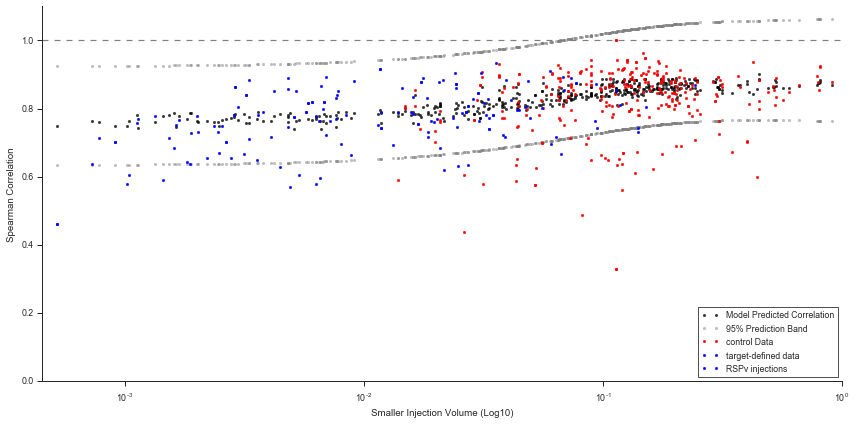

In [214]:
fig, ax = plt.subplots(figsize = (12, 6))
ax.plot(both['injection_size'].values, both['predicted_spearman'].values, '.', color='k', 
        label='Model Predicted Correlation',
        alpha=.8)
ax.plot(both['injection_size'].values, predband(both['injection_size'].values,
                                                          (both['injection_size'].values, 
                                                          both['mean_overlap'].values), 
                                                          both['spearman_correlation'].values, popt)[0], 
        '.', color='gray', label='95% Prediction Band',
        alpha=.5)
ax.plot(both['injection_size'].values, predband(both['injection_size'].values,
                                                          (both['injection_size'].values, 
                                                          both['mean_overlap'].values), 
                                                          both['spearman_correlation'].values, popt)[1],
        '.', color='gray',
        alpha=.5)
ax.plot(cmeans['injection_size'].values, cmeans['spearman_correlation'].values, 
        '.', color='red',
       label = 'control Data')
ax.plot(meandat['injection_size'].values, meandat['spearman_correlation'].values,
       '.', color = 'b', label = 'target-defined data')
ax.plot(meandat[meandat['source'] == 'RSPv']['injection_size'].values, 
        meandat[meandat['source'] == 'RSPv']['spearman_correlation'].values, 
       '.', color = 'blue', label = 'RSPv injections')
ax.set_xlabel('Smaller Injection Volume (Log10)')
ax.set_ylabel('Spearman Correlation')
ax.set_xscale('log')
ax.set_xlim([0.00045, 1])
ax.set_ylim([0, 1.1])
plt.axhline(y=1, color = 'gray', linestyle = '--')
ax.legend(loc=4)
sns.despine()
ax.tick_params(top=False, right=False)
ax.get_xaxis().set_tick_params(which='minor', size=0)
ax.get_xaxis().set_tick_params(which='minor', width=0) 
plt.tight_layout()

In [127]:
meandat.keys()

Index([u'image_series_id', u'spearman_correlation', u'predicted_spearman',
       u'exp_diff', u'number of comparisons', u'source', u'injection_size',
       u'mean_overlap'],
      dtype='object')

In [128]:
meandat['low_pred_band'] = predband(meandat['injection_size'].values,
                              (meandat['injection_size'].values, 
                               meandat['mean_overlap'].values), 
                              meandat['spearman_correlation'].values, popt)[0]

In [129]:
len(meandat[meandat['spearman_correlation'] < meandat['low_pred_band']])

18

In [130]:
meandat[meandat['spearman_correlation'] < meandat['low_pred_band']]['source'].unique()

array(['ECT', 'RE', 'VISp', 'ENTl', 'ORBvl', 'ENTm', 'VISpl', 'MD',
       'RSPv', 'ORBl', 'ACAv', 'AV'], dtype=object)

In [131]:
meandat[meandat['spearman_correlation'] < meandat['low_pred_band']]['image_series_id'].unique()

array([484612961, 496964969, 496965687, 501837158, 525413115, 526783792,
       531233132, 532005897, 539511058, 571410278, 578332611, 592522663,
       601804603, 607052300, 607316031, 609475139, 614435699, 617898760],
      dtype=int64)

In [132]:
cmeans['low_pred_band'] = predband(cmeans['injection_size'].values,
                              (cmeans['injection_size'].values, 
                               cmeans['mean_overlap'].values), 
                              cmeans['spearman_correlation'].values, popt)[0]

In [133]:
len(cmeans[cmeans['spearman_correlation'] < cmeans['low_pred_band']])

37

In [134]:
cmeans[cmeans['spearman_correlation'] < cmeans['low_pred_band']]['source'].unique()

array(['DG', 'AV', 'SSp-bfd', 'ENTm', 'ENTl', 'MD', 'AM', 'RE', 'VISpl',
       'SSp-m', 'VISp'], dtype=object)